# general

In [2]:
import s3fs
import fsspec
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import io
import skimage
from PIL import Image
import scipy
#from cellpose import utils, models
import glob
import seaborn as sns
from tqdm import tqdm
import pickle

In [3]:
#cell_labels = np.unique(masks)

def cut_to_label_bounds (masks, label, array_img):
    c_mask = np.where(np.array(masks)==label)
    bounds_0 = min(c_mask[0]), max(c_mask[0])
    bounds_1 = min(c_mask[1]), max(c_mask[1])
    bounds_2 = min(c_mask[2]), max(c_mask[2])

    cell_stack_mask = np.array(masks[:], dtype=float)
    cell_stack_mask[np.where(masks!=label)] = 0
    
    cell_stack_mask = cell_stack_mask[bounds_0[0]:bounds_0[1],bounds_1[0]:bounds_1[1],bounds_2[0]:bounds_2[1]]
    cell_stack_c0 = array_img[0][bounds_0[0]:bounds_0[1],bounds_1[0]:bounds_1[1],bounds_2[0]:bounds_2[1]]
    cell_stack_c1 = array_img[1][bounds_0[0]:bounds_0[1],bounds_1[0]:bounds_1[1],bounds_2[0]:bounds_2[1]]
    #print("post cut")
    #print(np.shape(cell_stack_mask))
    #print(np.shape(cell_stack_c0))
    #print(np.shape(cell_stack_c1))
    return np.array(cell_stack_mask,dtype=float), np.array(cell_stack_c0,dtype=float), np.array(cell_stack_c1, dtype=float)

def nan_mask_inplace (cell_mask, original):
    # print(np.shape(original))
    non_mask_pixels = np.where(cell_mask == 0)
    mask_pixels = np.nonzero(cell_mask)
    if not all([x >= 2 for x in np.shape(mask_pixels)]):
        return
    original[non_mask_pixels] = np.nan
    return original

# def simple_transforms ():


def compare_cells_hoechst_v_stain (cell_stack_mask, cell_stack_c0, cell_stack_c1, fn, mip, mip_axis, per_frame, cut_to_mask, norm, flatten, per_frame_aggfunc):
    assert(mip == (mip_axis is not None))
    if mip:
        assert(not per_frame)
        mip_mask = np.max(cell_stack_mask, axis=mip_axis)
        if cut_to_mask:
            mip_c0 = nan_mask_inplace(mip_mask, np.max(cell_stack_c0, axis=mip_axis))
            mip_c1 = nan_mask_inplace(mip_mask, np.max(cell_stack_c1, axis=mip_axis))
        
        if norm: 
            mip_c0 = mip_c0/np.sqrt(np.nansum(np.square(mip_c0)))
            mip_c1 = mip_c1/np.sqrt(np.nansum(np.square(mip_c1)))
        if flatten:
            mip_c0 = np.ravel(mip_c0)
            mip_c1 = np.ravel(mip_c1)
        res = fn(mip_c0, mip_c1)
        return res

    if cut_to_mask:
        nan_mask_inplace(cell_stack_mask, cell_stack_c0)
        nan_mask_inplace(cell_stack_mask, cell_stack_c1)
    if not per_frame:
        if flatten:
            cell_stack_c0 = np.ravel(cell_stack_c0)
            cell_stack_c1 = np.ravel(cell_stack_c1)
        if norm:
            cell_stack_c0 = cell_stack_c0/np.sqrt(np.nansum(np.square(cell_stack_c0)))
            cell_stack_c1 = cell_stack_c1/np.sqrt(np.nansum(np.square(cell_stack_c1)))
        res = fn(cell_stack_c0,cell_stack_c1)
        return res

    assert(per_frame)
    # if per frame and/or not MIP
    c_frames_res = []
    
    for i in tqdm(range(np.shape(cell_stack_mask)[0])):
        mask_slice = cell_stack_mask[i]
        if not all([x >= 2 for x in np.shape(mask_slice[np.logical_not(np.isnan(mask_slice))])]):
            continue
        c0_slice = cell_stack_c0[i]
        c1_slice = cell_stack_c1[i]
        if norm: 
            c0_slice = c0_slice/np.sqrt(np.nansum(np.square(c0_slice)))
            c1_slice = c1_slice/np.sqrt(np.nansum(np.square(c1_slice)))
        if flatten:
            c0_slice = np.ravel(c0_slice)
            c1_slice = np.ravel(c1_slice)
        
        res = fn(c0_slice,c1_slice) 
        c_frames_res.append(res)
    return per_frame_aggfunc(c_frames_res)

def hoechst_v_stain (array_img, masks, fn, cut_to_mask = True, norm=False, flatten = False, mip=False, mip_axis = None, per_frame=True, per_frame_aggfunc = lambda x : x, artifact_filter_level = 50):
    cell_labels = np.unique(masks)
    results = [] 
    for c in tqdm(cell_labels):
        if c == 0:
            continue
        cell_stack_mask, cell_stack_c0, cell_stack_c1 = cut_to_label_bounds(masks, c, array_img)
        dims = np.shape(cell_stack_c0)
        #print(dims)
        if dims[1] < artifact_filter_level or dims[2] < artifact_filter_level:
            continue
        res = compare_cells_hoechst_v_stain(cell_stack_mask=cell_stack_mask, cell_stack_c0=cell_stack_c0, cell_stack_c1=cell_stack_c1, fn = fn, mip = mip, mip_axis=mip_axis, per_frame=per_frame, cut_to_mask=cut_to_mask, norm=norm, flatten=flatten, per_frame_aggfunc=per_frame_aggfunc)
        results.append(res)
    return results

# import processed cells

In [8]:
# all polr2 subunits, raw images
with open("/Users/amulya/Desktop/Buenrostro_Lab/intranuclear-structures/res.pickle", "rb") as input_file:
    res = pickle.load(input_file)
with open("/Users/amulya/Desktop/Buenrostro_Lab/intranuclear-structures/res2.pickle", "rb") as input_file:
    res2 = pickle.load(input_file)
r = res|res2

In [5]:
# all polr2 subunits, shifted
with open("/Users/amulya/Desktop/Buenrostro_Lab/intranuclear-structures/pol_shifted_imgs.pickle", "rb") as input_file:
    shifted_res = pickle.load(input_file)

In [22]:
# all chromatin proteins
with open("C:\\Users\\amulya\\Documents\\intranuclear-structures\\chromatin_images.npy", "rb") as input_file:
    r = np.load(input_file)

import pandas as pd
labels = pd.read_csv("C:\\Users\\amulya\\Downloads\\cytoself_all_labels.csv.csv")
chrom_labels = labels.loc[["chrom" in str(x) for x in labels.loc_grade1]]
labeled_chromatin_results = list(zip(chrom_labels["name"], r))

# xcorr surface viz

In [16]:
from mpl_toolkits.mplot3d import Axes3D  

#corrs = {}
def xcorrviz (a, b):
    try:
        xc_notnan = scipy.signal.correlate(a[np.logical_not(np.isnan(a))], b[np.logical_not(np.isnan(b))], mode='full')
    except Exception as e:
        print(e)
        return -1
    a[np.isnan(a)] = 0
    b[np.isnan(b)] = 0
    xc = scipy.signal.correlate(a, b, mode='full')
    if (len(np.shape(xc)) == 2):
        print(np.mean(xc_notnan))
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        X, Y = np.meshgrid(np.arange(np.shape(xc)[0]), np.arange(np.shape(xc)[1]))
        ax.plot_surface(X, Y, xc.T)
        ax.set_zlim(ax.get_zlim()[0],1)
        plt.show()
        plt.clf()
        plt.imshow(a)
        plt.show()
        plt.clf()
        plt.imshow(b)
        plt.show()
        plt.clf()
    return xc

for k, (v0, v1, v2) in r.items():
    print(k)
    hoechst_v_stain(v0, v1, fn = xcorrviz,  norm=True,flatten=False,per_frame=True, per_frame_aggfunc = lambda x : x)

POLR2A
(73, 53, 86)
(3, 133564)


ValueError: operands could not be broadcast together with shapes (3,) (2,) 

# NCC - WITHOUT masking

In [51]:
xcorrs_norm_constrained = {}

"""def xcorr_and_print (a,b):
    xc = scipy.signal.correlate(a,b)
    print(xc)
    return xc"""

for k, (v0, v1, _) in r.items():
    if k == "POLR2B":
        continue
    print(k)
    # print(v1)
    xcorrs_norm_constrained[k] = hoechst_v_stain(v0, v1, fn = lambda a,b: scipy.signal.correlate(a,b), cut_to_mask=False, norm=True,flatten=False,per_frame=False)

POLR2A


100%|██████████| 39/39 [01:04<00:00,  1.65s/it]


POLR2C


100%|██████████| 49/49 [01:14<00:00,  1.52s/it]


POLR2D


100%|██████████| 183/183 [05:30<00:00,  1.80s/it]


POLR2E


100%|██████████| 229/229 [05:28<00:00,  1.44s/it]


POLR2F


100%|██████████| 411/411 [11:42<00:00,  1.71s/it]


POLR2G


100%|██████████| 92/92 [03:50<00:00,  2.51s/it]


POLR2H


100%|██████████| 54/54 [03:14<00:00,  3.60s/it]


POLR2I


100%|██████████| 47/47 [05:12<00:00,  6.65s/it]


POLR2K


100%|██████████| 58/58 [06:37<00:00,  6.85s/it]


POLR2J


100%|██████████| 59/59 [07:46<00:00,  7.91s/it]


In [52]:
import pickle
with open("pol_xcorrs_3dcell_norm.pickle", "wb") as output_file:
    pickle.dump(xcorrs_norm, output_file)

In [5]:
with open("pol_xcorrs_3dcell_norm.pickle", "rb") as input_file:
    xcorrs_norm = pickle.load(input_file)

Text(0.5, 0.98, 'POLR2* vs. Hoechst - max xcorr')

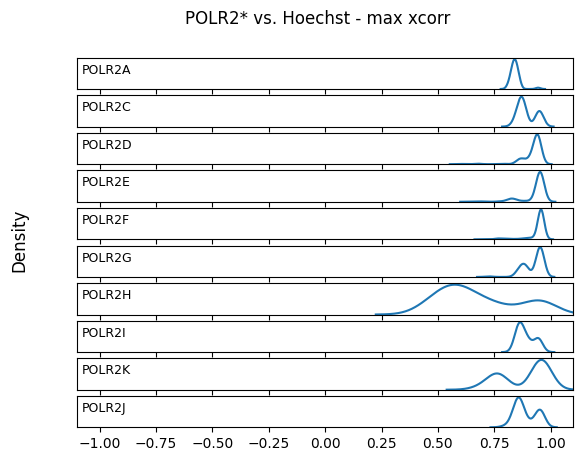

In [6]:
to_plot = {k : [np.max(x) for x in v] for k, v in xcorrs_norm.items()}
fig, axes = plt.subplots(ncols=1, nrows=len(to_plot), sharex=True)

for i in range(len(xcorrs_norm.keys())):
    k = list(to_plot.keys())[i]
    ax_to_use = axes[i]
    sns.kdeplot(x=to_plot[k], ax=ax_to_use, label=k)
    ax_to_use.set_ylabel("")
    ax_to_use.set_yticks([])
    ax_to_use.set_xlim((-1.1,1.1))
    ax_to_use.text(0.01,0.5, k, transform=ax_to_use.transAxes, size=9)

fig.supylabel("Density")
fig.suptitle("POLR2* vs. Hoechst - max xcorr")

# correlations w/ artifact removal

In [ ]:
corrs = {}
for k, (v0, v1, v2) in r.items():
    print(k)
    if k == "POL2RB":
        continue
    print(np.shape(v0))
    if np.shape(v0)[1] < 50 or np.shape(v0)[2] < 50:
        continue
    corrs[k] = hoechst_v_stain(v0, v1, fn = lambda a,b: scipy.stats.pearsonr(a,b)[0], norm=False,flatten=True,per_frame=True)

In [ ]:
fig, axes = plt.subplots(ncols=1, nrows=len(corrs), sharex=True)

for i in range(len(corrs.keys())):
    k = list(corrs.keys())[i]
    ax_to_use = axes[i]
    sns.kdeplot(x=np.hstack(corrs[k]), ax=ax_to_use, label=k)
    ax_to_use.set_ylabel("")
    ax_to_use.set_yticks([])
    ax_to_use.set_xlim((-1,1))
    ax_to_use.text(0.01,0.5, k, transform=ax_to_use.transAxes, size=9)

fig.supylabel("Density")
fig.suptitle("POLR2* vs. Hoechst - Pearson r")

# register images

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  

for k, (v0, v1, _) in r.items():
    print(k)
    img = v0
    mask = v1
    xcorrs_norm[k]
    
    
    hoechst_v_stain(v0, v1, fn = xcorrviz,  norm=True,flatten=False,per_frame=True, per_frame_aggfunc = lambda x : x)
    

In [24]:
labeled_chromatin_results[1]

('MED25',
 array([[[ 9.24860034e-03,  1.45871826e-02, -3.26496544e+01,
           0.00000000e+00],
         [ 1.31021831e-02,  1.28610330e-02, -3.22024841e+01,
           0.00000000e+00],
         [ 1.06924744e-02,  1.45750269e-02, -3.17804966e+01,
           0.00000000e+00],
         ...,
         [ 2.69653276e-02,  2.25736648e-02, -1.14017544e+01,
           0.00000000e+00],
         [ 1.94044989e-02,  2.30599046e-02, -1.17046995e+01,
           0.00000000e+00],
         [ 1.97752230e-02,  2.23183893e-02, -1.20830460e+01,
           0.00000000e+00]],
 
        [[ 1.32777896e-02,  1.58270933e-02, -3.17647610e+01,
           0.00000000e+00],
         [ 1.03705293e-02,  1.64227374e-02, -3.13049526e+01,
           0.00000000e+00],
         [ 1.00973640e-02,  1.43319070e-02, -3.08706989e+01,
           0.00000000e+00],
         ...,
         [ 1.62923653e-02,  2.02761833e-02, -1.04403067e+01,
           0.00000000e+00],
         [ 1.59216411e-02,  2.46037152e-02, -1.07703295e+01,
        

In [49]:
def show_mips_rb (c0, c1, title=""):
    plt.imshow(np.max(c0,axis=0), cmap="Reds",alpha=0.5)
    plt.imshow(np.max(c1,axis=0), cmap="Blues",alpha=0.5)
    plt.title(f"{title}x-y MIP - stain overlay")
    plt.show()
    plt.clf()
    plt.imshow(np.max(c0,axis=1), cmap="Reds",alpha=0.5)
    plt.imshow(np.max(c1,axis=1), cmap="Blues",alpha=0.5)
    plt.title(f"{title}y-z MIP - stain overlay")
    plt.show()
    plt.clf()
    plt.imshow(np.max(c0,axis=2), cmap="Reds",alpha=0.5)
    plt.imshow(np.max(c1,axis=2), cmap="Blues",alpha=0.5)
    plt.title(f"{title}x-z MIP - stain overlay")
    plt.show()
    plt.clf()

shifted_imgs = []

# TODO: reconfigure such that shifted_imgs has same layout as other results
# shifted imgs = 
# subunit : (list of ORIG array images with cell stack 0 and 1, list of SHIFTED "", list of masks, list of detected shifts)
for subunit, (array_img, masks=None, _) in r:
    if subunit == "POLR2B":
        continue
    if masks is None:
            masks = array_img[-1]
    cell_labels = np.unique(masks)
    results = [] 
    for c in tqdm(cell_labels):
        if c == 0:
            continue
        cell_stack_mask, cell_stack_c0, cell_stack_c1 = cut_to_label_bounds(masks, c, array_img)
        detected_shift, _, _ = skimage.registration.phase_cross_correlation(cell_stack_c0, cell_stack_c1, normalization=None)
        c1_shifted = scipy.ndimage.shift(cell_stack_c1,detected_shift)
        # Each channel
        """plt.imshow(np.max(cell_stack_c0,axis=0))
        plt.title("z MIP - c0")
        plt.show()
        plt.imshow(np.max(c0_shifted,axis=0))
        plt.title("z MIP - c0 shifted")
        plt.show()
        plt.imshow(np.max(cell_stack_c1,axis=0))
        plt.title("z MIP - c1")
        plt.show()
        plt.imshow(np.max(c1_shifted,axis=0))
        plt.title("z MIP - c1 shifted")
        plt.show()"""

        #show_mips_rb(cell_stack_c0, cell_stack_c1)
        #show_mips_rb(cell_stack_c0, c1_shifted, title = "SHIFTED: ")
        if subunit not in shifted_imgs:
            shifted_imgs[subunit] = []
        shifted_imgs.append((subunit,(cell_stack_c0, cell_stack_c1, cell_stack_mask, c1_shifted, detected_shift)))
        # Stain offset
        """for i in range(np.shape(shifted_image)[0]):
            plt.imshow(shifted_image[i])
            plt.show()"""

        

  3%|▎         | 1/39 [00:02<01:44,  2.74s/it]


KeyboardInterrupt: 

In [6]:
z_shifts = { subunit : [c[4][0] for c in cells]  for subunit, cells in shifted_imgs.items()}
x_shifts = { subunit : [c[4][1] for c in cells]  for subunit, cells in shifted_imgs.items()}
y_shifts = { subunit : [c[4][2] for c in cells]  for subunit, cells in shifted_imgs.items()}

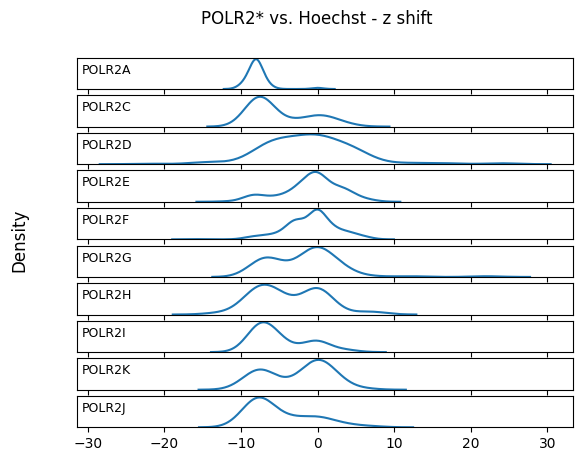

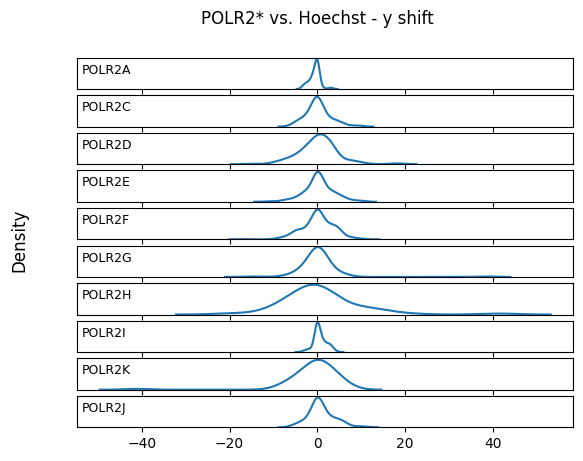

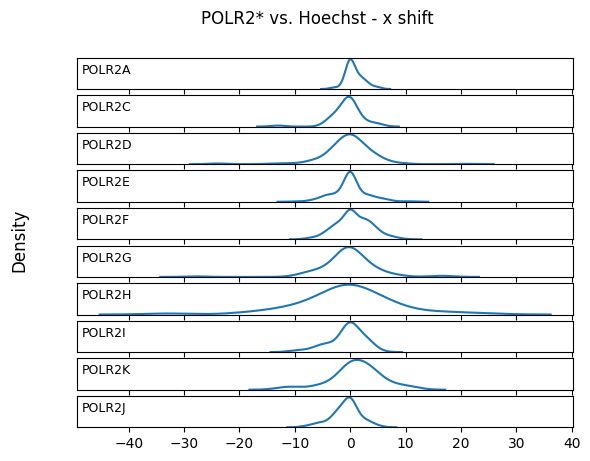

In [11]:

def plot_shifts(shifts, axis):
    fig, axes = plt.subplots(ncols=1, nrows=len(shifts), sharex=True)
    for i in range(len(shifts.keys())):
        k = list(shifts.keys())[i]
        ax_to_use = axes[i]
        sns.kdeplot(x=np.hstack(shifts[k]), ax=ax_to_use, label=str(shifts))
        ax_to_use.set_ylabel("")
        ax_to_use.set_yticks([])
        ax_to_use.text(0.01,0.5, k, transform=ax_to_use.transAxes, size=9)
    fig.supylabel("Density")
    fig.suptitle(f"POLR2* vs. Hoechst - {axis} shift")

plot_shifts(z_shifts, "z")
plot_shifts(y_shifts, "y")
plot_shifts(x_shifts, "x")

## compare shifted cell images

In [ ]:
def compare_shifted (shifted_imgs, fn, mip = False, mip_axis = None, per_frame = False, cut_to_mask = True, norm = False, flatten = False, per_frame_aggfunc = lambda x : x, artifact_filter_level=0):
    orig_shifted_res = {}
    for subunit, cells in shifted_imgs.items():
        res = []
        for c in tqdm(cells):
            cell_stack_c0, cell_stack_c1, cell_stack_mask, c1_shifted = c
            dims = np.shape(cell_stack_c0)
            #print(dims)
            if dims[1] < artifact_filter_level or dims[2] < artifact_filter_level:
                continue
            res_shifted = compare_cells_hoechst_v_stain (cell_stack_mask=cell_stack_mask, cell_stack_c0=cell_stack_c0, cell_stack_c1=c1_shifted, fn=fn, mip=mip, mip_axis=mip_axis, per_frame=per_frame, cut_to_mask=cut_to_mask, norm=norm, flatten=flatten, per_frame_aggfunc=per_frame_aggfunc)
            res_orig = compare_cells_hoechst_v_stain (cell_stack_mask=cell_stack_mask, cell_stack_c0=cell_stack_c0, cell_stack_c1=cell_stack_c1, fn=fn, mip=mip, mip_axis=mip_axis, per_frame=per_frame, cut_to_mask=cut_to_mask, norm=norm, flatten=flatten, per_frame_aggfunc=per_frame_aggfunc)
            res.append((res_orig, res_shifted))
        orig_shifted_res[subunit] = res
    return orig_shifted_res

### correlations

In [18]:
def correlate_mask_nans (a,b):
    bad = ~np.logical_or(np.isnan(a), np.isnan(b))
    good_a = np.compress(bad, a)
    good_b = np.compress(bad, b)
    if len(good_a) < 2 or len(good_b) < 2:
        return np.nan, np.nan
    return scipy.stats.pearsonr(good_a, good_b)

corrs_shifted = compare_shifted(shifted_imgs, fn = lambda a,b :correlate_mask_nans(a,b)[0], per_frame=True, flatten=True)

  0%|          | 0/76 [00:00<?, ?it/s]

(73, 53, 86)
(73, 53, 86)


/Users/amulya/anaconda3/envs/cytoself/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
100%|██████████| 73/73 [00:00<00:00, 781.83it/s]


(73, 53, 86)
(73, 53, 86)


  1%|▏         | 1/76 [00:00<00:16,  4.52it/s]

(63, 74, 77)
(63, 74, 77)


100%|██████████| 63/63 [00:00<00:00, 1083.35it/s]


(63, 74, 77)
(63, 74, 77)


  3%|▎         | 2/76 [00:00<00:14,  4.95it/s]

(64, 71, 76)
(64, 71, 76)


100%|██████████| 64/64 [00:00<00:00, 338.31it/s]


(64, 71, 76)
(64, 71, 76)


  4%|▍         | 3/76 [00:00<00:20,  3.60it/s]

(60, 84, 72)
(60, 84, 72)


100%|██████████| 60/60 [00:00<00:00, 981.45it/s]


(60, 84, 72)
(60, 84, 72)


  5%|▌         | 4/76 [00:00<00:17,  4.13it/s]

(63, 85, 82)
(63, 85, 82)


100%|██████████| 63/63 [00:00<00:00, 863.87it/s]


(63, 85, 82)
(63, 85, 82)


  7%|▋         | 5/76 [00:01<00:16,  4.25it/s]

(62, 68, 67)
(62, 68, 67)


100%|██████████| 62/62 [00:00<00:00, 1079.44it/s]


(62, 68, 67)
(62, 68, 67)


  8%|▊         | 6/76 [00:01<00:14,  4.75it/s]

(63, 87, 83)
(63, 87, 83)


100%|██████████| 63/63 [00:00<00:00, 1098.86it/s]


(63, 87, 83)
(63, 87, 83)


  9%|▉         | 7/76 [00:01<00:13,  4.93it/s]

(60, 64, 69)
(60, 64, 69)


100%|██████████| 60/60 [00:00<00:00, 965.08it/s]


(60, 64, 69)
(60, 64, 69)


 11%|█         | 8/76 [00:01<00:13,  5.20it/s]

(62, 99, 93)
(62, 99, 93)


100%|██████████| 62/62 [00:00<00:00, 970.64it/s]


(62, 99, 93)
(62, 99, 93)


 12%|█▏        | 9/76 [00:01<00:13,  5.06it/s]

(60, 85, 91)
(60, 85, 91)


100%|██████████| 60/60 [00:00<00:00, 627.27it/s]


(60, 85, 91)
(60, 85, 91)


 13%|█▎        | 10/76 [00:02<00:13,  4.80it/s]

(59, 73, 73)
(59, 73, 73)


100%|██████████| 59/59 [00:00<00:00, 973.29it/s]


(59, 73, 73)
(59, 73, 73)


 14%|█▍        | 11/76 [00:02<00:12,  5.13it/s]

Skip
(65, 76, 64)
(65, 76, 64)


100%|██████████| 65/65 [00:00<00:00, 1113.40it/s]


(65, 76, 64)
(65, 76, 64)


 17%|█▋        | 13/76 [00:02<00:08,  7.04it/s]

(60, 71, 69)
(60, 71, 69)


100%|██████████| 60/60 [00:00<00:00, 1051.84it/s]


(60, 71, 69)
(60, 71, 69)


 18%|█▊        | 14/76 [00:02<00:08,  6.94it/s]

(61, 72, 71)
(61, 72, 71)


100%|██████████| 61/61 [00:00<00:00, 1107.26it/s]


(61, 72, 71)
(61, 72, 71)


 20%|█▉        | 15/76 [00:02<00:08,  6.78it/s]

(62, 62, 71)
(62, 62, 71)


100%|██████████| 62/62 [00:00<00:00, 1029.68it/s]


(62, 62, 71)
(62, 62, 71)


 21%|██        | 16/76 [00:02<00:09,  6.60it/s]

(58, 67, 83)
(58, 67, 83)


100%|██████████| 58/58 [00:00<00:00, 1026.79it/s]


(58, 67, 83)
(58, 67, 83)


 22%|██▏       | 17/76 [00:03<00:09,  6.38it/s]

(61, 77, 67)
(61, 77, 67)


100%|██████████| 61/61 [00:00<00:00, 757.74it/s]


(61, 77, 67)
(61, 77, 67)


 24%|██▎       | 18/76 [00:03<00:09,  5.89it/s]

(59, 66, 69)
(59, 66, 69)


100%|██████████| 59/59 [00:00<00:00, 1025.84it/s]


(59, 66, 69)
(59, 66, 69)


 25%|██▌       | 19/76 [00:03<00:09,  5.76it/s]

Skip
(55, 96, 74)
(55, 96, 74)


100%|██████████| 55/55 [00:00<00:00, 890.56it/s]


(55, 96, 74)
(55, 96, 74)


 28%|██▊       | 21/76 [00:03<00:07,  7.33it/s]

(57, 87, 69)
(57, 87, 69)


100%|██████████| 57/57 [00:00<00:00, 961.44it/s]


(57, 87, 69)
(57, 87, 69)


 29%|██▉       | 22/76 [00:03<00:07,  6.93it/s]

(58, 77, 61)
(58, 77, 61)


100%|██████████| 58/58 [00:00<00:00, 1110.75it/s]


(58, 77, 61)
(58, 77, 61)


 30%|███       | 23/76 [00:03<00:07,  6.93it/s]

(62, 85, 92)
(62, 85, 92)


100%|██████████| 62/62 [00:00<00:00, 1021.78it/s]


(62, 85, 92)
(62, 85, 92)


 32%|███▏      | 24/76 [00:04<00:08,  6.41it/s]

(56, 92, 89)
(56, 92, 89)


100%|██████████| 56/56 [00:00<00:00, 992.98it/s]


(56, 92, 89)
(56, 92, 89)


 33%|███▎      | 25/76 [00:04<00:08,  5.80it/s]

(59, 64, 109)
(59, 64, 109)


100%|██████████| 59/59 [00:00<00:00, 913.89it/s]


(59, 64, 109)
(59, 64, 109)


 34%|███▍      | 26/76 [00:04<00:08,  5.62it/s]

(59, 70, 88)
(59, 70, 88)


100%|██████████| 59/59 [00:00<00:00, 1009.20it/s]


(59, 70, 88)
(59, 70, 88)


 36%|███▌      | 27/76 [00:04<00:09,  5.42it/s]

Skip
Skip
(59, 86, 108)
(59, 86, 108)


100%|██████████| 59/59 [00:00<00:00, 942.51it/s]


(59, 86, 108)
(59, 86, 108)


 39%|███▉      | 30/76 [00:04<00:05,  8.46it/s]

(56, 79, 22)
(56, 79, 22)


100%|██████████| 56/56 [00:00<00:00, 1158.45it/s]


(56, 79, 22)
(56, 79, 22)


 41%|████      | 31/76 [00:05<00:05,  8.39it/s]

(57, 88, 62)
(57, 88, 62)


100%|██████████| 57/57 [00:00<00:00, 1076.10it/s]


(57, 88, 62)
(57, 88, 62)


 42%|████▏     | 32/76 [00:05<00:05,  7.87it/s]

(60, 76, 73)
(60, 76, 73)


100%|██████████| 60/60 [00:00<00:00, 1027.57it/s]


(60, 76, 73)
(60, 76, 73)


 43%|████▎     | 33/76 [00:05<00:05,  7.32it/s]

(59, 86, 75)
(59, 86, 75)


100%|██████████| 59/59 [00:00<00:00, 639.63it/s]


(59, 86, 75)
(59, 86, 75)


 45%|████▍     | 34/76 [00:05<00:06,  6.44it/s]

Skip
Skip
(57, 64, 80)
(57, 64, 80)


100%|██████████| 57/57 [00:00<00:00, 1011.83it/s]


(57, 64, 80)
(57, 64, 80)


 49%|████▊     | 37/76 [00:05<00:03,  9.99it/s]

Skip
(73, 53, 86)
(73, 53, 86)


100%|██████████| 73/73 [00:00<00:00, 1088.16it/s]


(73, 53, 86)
(73, 53, 86)


 51%|█████▏    | 39/76 [00:05<00:03, 10.35it/s]

(63, 74, 77)
(63, 74, 77)


100%|██████████| 63/63 [00:00<00:00, 1052.28it/s]


(63, 74, 77)
(63, 74, 77)


100%|██████████| 63/63 [00:00<00:00, 913.39it/s]


(64, 71, 76)
(64, 71, 76)


100%|██████████| 64/64 [00:00<00:00, 995.55it/s]


(64, 71, 76)
(64, 71, 76)


 54%|█████▍    | 41/76 [00:06<00:04,  7.99it/s]

(60, 84, 72)
(60, 84, 72)


100%|██████████| 60/60 [00:00<00:00, 1170.44it/s]


(60, 84, 72)
(60, 84, 72)


 55%|█████▌    | 42/76 [00:06<00:04,  7.53it/s]

(63, 85, 82)
(63, 85, 82)


100%|██████████| 63/63 [00:00<00:00, 892.49it/s]


(63, 85, 82)
(63, 85, 82)


 57%|█████▋    | 43/76 [00:06<00:04,  6.80it/s]

(62, 68, 67)
(62, 68, 67)


100%|██████████| 62/62 [00:00<00:00, 847.09it/s]


(62, 68, 67)
(62, 68, 67)


 58%|█████▊    | 44/76 [00:06<00:05,  6.06it/s]

(63, 87, 83)
(63, 87, 83)


100%|██████████| 63/63 [00:00<00:00, 1015.44it/s]


(63, 87, 83)
(63, 87, 83)


 59%|█████▉    | 45/76 [00:07<00:05,  5.91it/s]

(60, 64, 69)
(60, 64, 69)


100%|██████████| 60/60 [00:00<00:00, 1136.90it/s]


(60, 64, 69)
(60, 64, 69)


 61%|██████    | 46/76 [00:07<00:04,  6.12it/s]

(62, 99, 93)
(62, 99, 93)


100%|██████████| 62/62 [00:00<00:00, 974.92it/s]


(62, 99, 93)
(62, 99, 93)


 62%|██████▏   | 47/76 [00:07<00:05,  5.75it/s]

(60, 85, 91)
(60, 85, 91)


100%|██████████| 60/60 [00:00<00:00, 938.92it/s]


(60, 85, 91)
(60, 85, 91)


 63%|██████▎   | 48/76 [00:07<00:05,  5.56it/s]

(59, 73, 73)
(59, 73, 73)


100%|██████████| 59/59 [00:00<00:00, 1029.71it/s]


(59, 73, 73)
(59, 73, 73)


 64%|██████▍   | 49/76 [00:07<00:04,  5.69it/s]

Skip
(65, 76, 64)
(65, 76, 64)


100%|██████████| 65/65 [00:00<00:00, 1147.23it/s]


(65, 76, 64)
(65, 76, 64)


 67%|██████▋   | 51/76 [00:08<00:03,  6.69it/s]

(60, 71, 69)
(60, 71, 69)


100%|██████████| 60/60 [00:00<00:00, 983.50it/s]


(60, 71, 69)
(60, 71, 69)


 68%|██████▊   | 52/76 [00:08<00:03,  6.13it/s]

(61, 72, 71)
(61, 72, 71)


100%|██████████| 61/61 [00:00<00:00, 938.71it/s]


(61, 72, 71)
(61, 72, 71)


 70%|██████▉   | 53/76 [00:08<00:03,  6.00it/s]

(62, 62, 71)
(62, 62, 71)


100%|██████████| 62/62 [00:00<00:00, 1049.26it/s]


(62, 62, 71)
(62, 62, 71)


 71%|███████   | 54/76 [00:08<00:03,  6.09it/s]

(58, 67, 83)
(58, 67, 83)


100%|██████████| 58/58 [00:00<00:00, 1042.40it/s]


(58, 67, 83)
(58, 67, 83)


 72%|███████▏  | 55/76 [00:08<00:03,  6.14it/s]

(61, 77, 67)
(61, 77, 67)


100%|██████████| 61/61 [00:00<00:00, 1096.09it/s]


(61, 77, 67)
(61, 77, 67)


 74%|███████▎  | 56/76 [00:08<00:03,  6.20it/s]

(59, 66, 69)
(59, 66, 69)


100%|██████████| 59/59 [00:00<00:00, 1078.81it/s]


(59, 66, 69)
(59, 66, 69)


 75%|███████▌  | 57/76 [00:09<00:02,  6.35it/s]

Skip
(55, 96, 74)
(55, 96, 74)


100%|██████████| 55/55 [00:00<00:00, 1046.52it/s]


(55, 96, 74)
(55, 96, 74)


 78%|███████▊  | 59/76 [00:09<00:02,  7.79it/s]

(57, 87, 69)
(57, 87, 69)


100%|██████████| 57/57 [00:00<00:00, 1049.47it/s]


(57, 87, 69)
(57, 87, 69)


 79%|███████▉  | 60/76 [00:09<00:02,  7.23it/s]

(58, 77, 61)
(58, 77, 61)


100%|██████████| 58/58 [00:00<00:00, 1108.12it/s]


(58, 77, 61)
(58, 77, 61)


 80%|████████  | 61/76 [00:09<00:02,  7.10it/s]

(62, 85, 92)
(62, 85, 92)


100%|██████████| 62/62 [00:00<00:00, 922.29it/s]


(62, 85, 92)
(62, 85, 92)


 82%|████████▏ | 62/76 [00:09<00:02,  6.41it/s]

(56, 92, 89)
(56, 92, 89)


100%|██████████| 56/56 [00:00<00:00, 887.33it/s]


(56, 92, 89)
(56, 92, 89)


 83%|████████▎ | 63/76 [00:09<00:02,  6.09it/s]

(59, 64, 109)
(59, 64, 109)


100%|██████████| 59/59 [00:00<00:00, 1067.08it/s]


(59, 64, 109)
(59, 64, 109)


 84%|████████▍ | 64/76 [00:10<00:01,  6.03it/s]

(59, 70, 88)
(59, 70, 88)


100%|██████████| 59/59 [00:00<00:00, 1034.89it/s]


(59, 70, 88)
(59, 70, 88)


 86%|████████▌ | 65/76 [00:10<00:01,  5.95it/s]

Skip
Skip
(59, 86, 108)
(59, 86, 108)


100%|██████████| 59/59 [00:00<00:00, 712.04it/s]


(59, 86, 108)
(59, 86, 108)


 89%|████████▉ | 68/76 [00:10<00:00,  8.64it/s]

(56, 79, 22)
(56, 79, 22)


100%|██████████| 56/56 [00:00<00:00, 1066.79it/s]


(56, 79, 22)
(56, 79, 22)


 91%|█████████ | 69/76 [00:10<00:00,  8.42it/s]

(57, 88, 62)
(57, 88, 62)


100%|██████████| 57/57 [00:00<00:00, 1004.95it/s]


(57, 88, 62)
(57, 88, 62)


 92%|█████████▏| 70/76 [00:10<00:00,  7.85it/s]

(60, 76, 73)
(60, 76, 73)


100%|██████████| 60/60 [00:00<00:00, 973.06it/s]


(60, 76, 73)
(60, 76, 73)


 93%|█████████▎| 71/76 [00:10<00:00,  7.24it/s]

(59, 86, 75)
(59, 86, 75)


100%|██████████| 59/59 [00:00<00:00, 964.73it/s]


(59, 86, 75)
(59, 86, 75)


 95%|█████████▍| 72/76 [00:11<00:00,  6.81it/s]

Skip
Skip
(57, 64, 80)
(57, 64, 80)


100%|██████████| 57/57 [00:00<00:00, 632.03it/s]


(57, 64, 80)
(57, 64, 80)


100%|██████████| 76/76 [00:11<00:00,  6.71it/s]


Skip


  0%|          | 0/753 [00:00<?, ?it/s]

(59, 86, 87)
(59, 86, 87)


100%|██████████| 59/59 [00:00<00:00, 955.78it/s]


(59, 86, 87)
(59, 86, 87)


  0%|          | 1/753 [00:00<03:07,  4.00it/s]

(62, 133, 113)
(62, 133, 113)


100%|██████████| 62/62 [00:00<00:00, 864.20it/s]


(62, 133, 113)
(62, 133, 113)


  0%|          | 2/753 [00:00<03:17,  3.79it/s]

(66, 134, 116)
(66, 134, 116)


100%|██████████| 66/66 [00:00<00:00, 987.43it/s]


(66, 134, 116)
(66, 134, 116)


  0%|          | 3/753 [00:00<03:22,  3.70it/s]

(56, 109, 73)
(56, 109, 73)


100%|██████████| 56/56 [00:00<00:00, 996.92it/s]


(56, 109, 73)
(56, 109, 73)


  1%|          | 4/753 [00:00<02:53,  4.33it/s]

(60, 83, 80)
(60, 83, 80)


100%|██████████| 60/60 [00:00<00:00, 1092.85it/s]


(60, 83, 80)
(60, 83, 80)


  1%|          | 5/753 [00:01<02:36,  4.78it/s]

(55, 113, 87)
(55, 113, 87)


100%|██████████| 55/55 [00:00<00:00, 962.70it/s]


(55, 113, 87)
(55, 113, 87)


  1%|          | 6/753 [00:01<02:30,  4.96it/s]

(60, 88, 84)
(60, 88, 84)


100%|██████████| 60/60 [00:00<00:00, 962.43it/s]


(60, 88, 84)
(60, 88, 84)


  1%|          | 7/753 [00:01<02:44,  4.53it/s]

(62, 72, 63)
(62, 72, 63)


100%|██████████| 62/62 [00:00<00:00, 1075.60it/s]


(62, 72, 63)
(62, 72, 63)


  1%|          | 8/753 [00:01<02:29,  4.98it/s]

Skip
(56, 118, 84)
(56, 118, 84)


100%|██████████| 56/56 [00:00<00:00, 959.74it/s]


(56, 118, 84)
(56, 118, 84)


  1%|▏         | 10/753 [00:01<01:51,  6.65it/s]

(59, 88, 86)
(59, 88, 86)


100%|██████████| 59/59 [00:00<00:00, 1054.54it/s]


(59, 88, 86)
(59, 88, 86)


  1%|▏         | 11/753 [00:02<01:58,  6.24it/s]

(61, 87, 74)
(61, 87, 74)


100%|██████████| 61/61 [00:00<00:00, 954.58it/s]


(61, 87, 74)
(61, 87, 74)


  2%|▏         | 12/753 [00:02<02:02,  6.03it/s]

(66, 90, 69)
(66, 90, 69)


100%|██████████| 66/66 [00:00<00:00, 1053.25it/s]


(66, 90, 69)
(66, 90, 69)


  2%|▏         | 13/753 [00:02<02:05,  5.88it/s]

(62, 126, 82)
(62, 126, 82)


100%|██████████| 62/62 [00:00<00:00, 988.08it/s]


(62, 126, 82)
(62, 126, 82)


  2%|▏         | 14/753 [00:02<02:34,  4.79it/s]

(65, 67, 70)
(65, 67, 70)


100%|██████████| 65/65 [00:00<00:00, 930.09it/s]


(65, 67, 70)
(65, 67, 70)


  2%|▏         | 15/753 [00:02<02:28,  4.97it/s]

(62, 156, 144)
(62, 156, 144)


100%|██████████| 62/62 [00:00<00:00, 743.22it/s]


(62, 156, 144)
(62, 156, 144)


  2%|▏         | 16/753 [00:03<03:09,  3.88it/s]

(62, 98, 75)
(62, 98, 75)


100%|██████████| 62/62 [00:00<00:00, 945.66it/s]


(62, 98, 75)
(62, 98, 75)


  2%|▏         | 17/753 [00:03<02:57,  4.16it/s]

(59, 79, 89)
(59, 79, 89)


100%|██████████| 59/59 [00:00<00:00, 1150.64it/s]


(59, 79, 89)
(59, 79, 89)


  2%|▏         | 18/753 [00:03<02:39,  4.60it/s]

(66, 118, 75)
(66, 118, 75)


100%|██████████| 66/66 [00:00<00:00, 936.65it/s]


(66, 118, 75)
(66, 118, 75)


  3%|▎         | 19/753 [00:03<02:40,  4.56it/s]

Skip
Skip
Skip
Skip
(59, 105, 91)
(59, 105, 91)


100%|██████████| 59/59 [00:00<00:00, 516.04it/s]


(59, 105, 91)
(59, 105, 91)


100%|██████████| 753/753 [00:04<00:00, 178.76it/s]


Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip


  0%|          | 0/48 [00:00<?, ?it/s]

(56, 100, 78)
(56, 100, 78)


100%|██████████| 56/56 [00:00<00:00, 997.10it/s]


(56, 100, 78)
(56, 100, 78)


  2%|▏         | 1/48 [00:00<00:07,  6.03it/s]

(68, 95, 80)
(68, 95, 80)


100%|██████████| 68/68 [00:00<00:00, 1046.09it/s]


(68, 95, 80)
(68, 95, 80)


  4%|▍         | 2/48 [00:00<00:08,  5.55it/s]

(66, 89, 52)
(66, 89, 52)


100%|██████████| 66/66 [00:00<00:00, 1143.59it/s]


(66, 89, 52)
(66, 89, 52)


  6%|▋         | 3/48 [00:00<00:07,  5.87it/s]

Skip
(66, 87, 92)
(66, 87, 92)


100%|██████████| 66/66 [00:00<00:00, 1007.59it/s]


(66, 87, 92)
(66, 87, 92)


 10%|█         | 5/48 [00:00<00:05,  7.80it/s]

(65, 93, 92)
(65, 93, 92)


100%|██████████| 65/65 [00:00<00:00, 1007.83it/s]


(65, 93, 92)
(65, 93, 92)


 12%|█▎        | 6/48 [00:00<00:06,  6.51it/s]

(69, 61, 64)
(69, 61, 64)


100%|██████████| 69/69 [00:00<00:00, 974.06it/s]


(69, 61, 64)
(69, 61, 64)


 15%|█▍        | 7/48 [00:01<00:07,  5.85it/s]

(64, 82, 89)
(64, 82, 89)


100%|██████████| 64/64 [00:00<00:00, 935.04it/s]


(64, 82, 89)
(64, 82, 89)


 17%|█▋        | 8/48 [00:01<00:07,  5.61it/s]

(58, 84, 80)
(58, 84, 80)


100%|██████████| 58/58 [00:00<00:00, 1010.08it/s]


(58, 84, 80)
(58, 84, 80)


 19%|█▉        | 9/48 [00:01<00:07,  5.52it/s]

(60, 110, 76)
(60, 110, 76)


100%|██████████| 60/60 [00:00<00:00, 832.13it/s]


(60, 110, 76)
(60, 110, 76)


 21%|██        | 10/48 [00:01<00:07,  5.36it/s]

(65, 71, 81)
(65, 71, 81)


100%|██████████| 65/65 [00:00<00:00, 981.53it/s]


(65, 71, 81)
(65, 71, 81)


 23%|██▎       | 11/48 [00:01<00:06,  5.32it/s]

(64, 52, 49)
(64, 52, 49)


100%|██████████| 64/64 [00:00<00:00, 1542.50it/s]


(64, 52, 49)
(64, 52, 49)


 25%|██▌       | 12/48 [00:02<00:06,  5.90it/s]

(63, 74, 59)
(63, 74, 59)


100%|██████████| 63/63 [00:00<00:00, 704.60it/s]


(63, 74, 59)
(63, 74, 59)


 27%|██▋       | 13/48 [00:02<00:06,  5.53it/s]

Skip
(60, 84, 68)
(60, 84, 68)


100%|██████████| 60/60 [00:00<00:00, 892.60it/s]


(60, 84, 68)
(60, 84, 68)


 31%|███▏      | 15/48 [00:02<00:04,  7.01it/s]

(62, 72, 89)
(62, 72, 89)


100%|██████████| 62/62 [00:00<00:00, 948.01it/s]


(62, 72, 89)
(62, 72, 89)


 33%|███▎      | 16/48 [00:02<00:04,  6.49it/s]

(65, 79, 78)
(65, 79, 78)


100%|██████████| 65/65 [00:00<00:00, 883.39it/s]


(65, 79, 78)
(65, 79, 78)


 35%|███▌      | 17/48 [00:02<00:05,  5.92it/s]

(62, 67, 93)
(62, 67, 93)


100%|██████████| 62/62 [00:00<00:00, 912.67it/s]

(62, 67, 93)


(62, 67, 93)


 38%|███▊      | 18/48 [00:03<00:05,  5.68it/s]

(62, 82, 70)
(62, 82, 70)


100%|██████████| 62/62 [00:00<00:00, 815.67it/s]

(62, 82, 70)


(62, 82, 70)


 40%|███▉      | 19/48 [00:03<00:05,  5.06it/s]

(59, 73, 85)
(59, 73, 85)


100%|██████████| 59/59 [00:00<00:00, 950.97it/s]


(59, 73, 85)
(59, 73, 85)


 42%|████▏     | 20/48 [00:03<00:05,  5.12it/s]

(61, 75, 79)
(61, 75, 79)


100%|██████████| 61/61 [00:00<00:00, 795.96it/s]


(61, 75, 79)
(61, 75, 79)


 44%|████▍     | 21/48 [00:03<00:05,  5.02it/s]

(59, 115, 65)
(59, 115, 65)


100%|██████████| 59/59 [00:00<00:00, 893.15it/s]


(59, 115, 65)
(59, 115, 65)


 46%|████▌     | 22/48 [00:03<00:05,  5.08it/s]

(61, 92, 89)
(61, 92, 89)


100%|██████████| 61/61 [00:00<00:00, 843.21it/s]


(61, 92, 89)
(61, 92, 89)


 48%|████▊     | 23/48 [00:04<00:05,  4.99it/s]

(63, 99, 66)
(63, 99, 66)


100%|██████████| 63/63 [00:00<00:00, 927.04it/s]


(63, 99, 66)
(63, 99, 66)


 50%|█████     | 24/48 [00:04<00:05,  4.67it/s]

(60, 70, 75)
(60, 70, 75)


100%|██████████| 60/60 [00:00<00:00, 818.75it/s]


(60, 70, 75)
(60, 70, 75)


 52%|█████▏    | 25/48 [00:04<00:04,  4.85it/s]

(63, 81, 83)
(63, 81, 83)


100%|██████████| 63/63 [00:00<00:00, 961.79it/s]


(63, 81, 83)
(63, 81, 83)


 54%|█████▍    | 26/48 [00:04<00:04,  5.00it/s]

(70, 74, 87)
(70, 74, 87)


100%|██████████| 70/70 [00:00<00:00, 939.50it/s]


(70, 74, 87)
(70, 74, 87)


 56%|█████▋    | 27/48 [00:04<00:04,  4.89it/s]

(63, 74, 71)
(63, 74, 71)


100%|██████████| 63/63 [00:00<00:00, 943.53it/s]

(63, 74, 71)


(63, 74, 71)


 58%|█████▊    | 28/48 [00:05<00:04,  4.83it/s]

(65, 85, 79)
(65, 85, 79)


100%|██████████| 65/65 [00:00<00:00, 903.22it/s]

(65, 85, 79)


(65, 85, 79)


 60%|██████    | 29/48 [00:05<00:03,  4.91it/s]

(74, 70, 78)
(74, 70, 78)


100%|██████████| 74/74 [00:00<00:00, 639.42it/s]


(74, 70, 78)
(74, 70, 78)


 62%|██████▎   | 30/48 [00:05<00:03,  4.63it/s]

(66, 75, 83)
(66, 75, 83)


100%|██████████| 66/66 [00:00<00:00, 964.02it/s]


(66, 75, 83)
(66, 75, 83)


 65%|██████▍   | 31/48 [00:05<00:03,  4.74it/s]

Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
(61, 65, 59)
(61, 65, 59)


100%|██████████| 61/61 [00:00<00:00, 878.10it/s]


(61, 65, 59)
(61, 65, 59)


 94%|█████████▍| 45/48 [00:05<00:00, 24.36it/s]

(58, 62, 73)
(58, 62, 73)


100%|██████████| 58/58 [00:00<00:00, 853.44it/s]


(58, 62, 73)
(58, 62, 73)


100%|██████████| 48/48 [00:06<00:00,  7.84it/s]


Skip
Skip


  0%|          | 0/182 [00:00<?, ?it/s]

(65, 93, 93)
(65, 93, 93)


100%|██████████| 65/65 [00:00<00:00, 932.17it/s]


(65, 93, 93)
(65, 93, 93)


  1%|          | 1/182 [00:00<00:38,  4.66it/s]

(57, 94, 91)
(57, 94, 91)


100%|██████████| 57/57 [00:00<00:00, 831.01it/s]


(57, 94, 91)
(57, 94, 91)


  1%|          | 2/182 [00:00<00:41,  4.32it/s]

(55, 98, 97)
(55, 98, 97)


100%|██████████| 55/55 [00:00<00:00, 887.49it/s]


(55, 98, 97)
(55, 98, 97)


  2%|▏         | 3/182 [00:00<00:39,  4.58it/s]

(64, 100, 105)
(64, 100, 105)


100%|██████████| 64/64 [00:00<00:00, 809.43it/s]


(64, 100, 105)
(64, 100, 105)


  2%|▏         | 4/182 [00:00<00:42,  4.15it/s]

(64, 88, 77)
(64, 88, 77)


100%|██████████| 64/64 [00:00<00:00, 947.13it/s]


(64, 88, 77)
(64, 88, 77)


  3%|▎         | 5/182 [00:01<00:39,  4.49it/s]

(50, 99, 74)
(50, 99, 74)


100%|██████████| 50/50 [00:00<00:00, 840.80it/s]


(50, 99, 74)
(50, 99, 74)


  3%|▎         | 6/182 [00:01<00:36,  4.85it/s]

(55, 90, 75)
(55, 90, 75)


100%|██████████| 55/55 [00:00<00:00, 861.60it/s]


(55, 90, 75)
(55, 90, 75)


  4%|▍         | 7/182 [00:01<00:38,  4.52it/s]

(61, 59, 71)
(61, 59, 71)


100%|██████████| 61/61 [00:00<00:00, 874.78it/s]


(61, 59, 71)
(61, 59, 71)


  4%|▍         | 8/182 [00:01<00:36,  4.83it/s]

(59, 80, 100)
(59, 80, 100)


100%|██████████| 59/59 [00:00<00:00, 893.06it/s]


(59, 80, 100)
(59, 80, 100)


  5%|▍         | 9/182 [00:01<00:36,  4.74it/s]

(65, 97, 103)
(65, 97, 103)


100%|██████████| 65/65 [00:00<00:00, 754.27it/s]


(65, 97, 103)
(65, 97, 103)


  5%|▌         | 10/182 [00:02<00:39,  4.40it/s]

(66, 105, 95)
(66, 105, 95)


100%|██████████| 66/66 [00:00<00:00, 755.63it/s]


(66, 105, 95)
(66, 105, 95)


  6%|▌         | 11/182 [00:02<00:47,  3.61it/s]

(57, 100, 106)
(57, 100, 106)


100%|██████████| 57/57 [00:00<00:00, 321.87it/s]


(57, 100, 106)
(57, 100, 106)


  7%|▋         | 12/182 [00:03<00:57,  2.94it/s]

(51, 68, 84)
(51, 68, 84)


100%|██████████| 51/51 [00:00<00:00, 526.91it/s]


(51, 68, 84)
(51, 68, 84)


  7%|▋         | 13/182 [00:03<00:55,  3.02it/s]

(58, 75, 134)
(58, 75, 134)


100%|██████████| 58/58 [00:00<00:00, 490.77it/s]

(58, 75, 134)
(58, 75, 134)



  8%|▊         | 14/182 [00:03<01:05,  2.55it/s]

(58, 58, 26)
(58, 58, 26)


100%|██████████| 58/58 [00:00<00:00, 591.50it/s]


(58, 58, 26)
(58, 58, 26)


  8%|▊         | 15/182 [00:04<00:59,  2.80it/s]

(59, 83, 73)
(59, 83, 73)


100%|██████████| 59/59 [00:00<00:00, 525.03it/s]


(59, 83, 73)
(59, 83, 73)


  9%|▉         | 16/182 [00:04<01:00,  2.76it/s]

(63, 93, 68)
(63, 93, 68)


100%|██████████| 63/63 [00:00<00:00, 419.83it/s]


(63, 93, 68)
(63, 93, 68)


  9%|▉         | 17/182 [00:04<01:02,  2.65it/s]

(63, 89, 89)
(63, 89, 89)


100%|██████████| 63/63 [00:00<00:00, 379.92it/s]


(63, 89, 89)
(63, 89, 89)


 10%|▉         | 18/182 [00:05<01:13,  2.24it/s]

(56, 87, 105)
(56, 87, 105)


100%|██████████| 56/56 [00:00<00:00, 379.03it/s]


(56, 87, 105)
(56, 87, 105)


 10%|█         | 19/182 [00:06<01:16,  2.12it/s]

(53, 65, 75)
(53, 65, 75)


100%|██████████| 53/53 [00:00<00:00, 676.59it/s]


(53, 65, 75)
(53, 65, 75)


 11%|█         | 20/182 [00:06<01:07,  2.38it/s]

Skip
(85, 89, 70)
(85, 89, 70)


100%|██████████| 85/85 [00:00<00:00, 620.67it/s]

(85, 89, 70)
(85, 89, 70)



 12%|█▏        | 22/182 [00:06<00:53,  2.98it/s]

(74, 59, 54)
(74, 59, 54)


100%|██████████| 74/74 [00:00<00:00, 909.54it/s]


(74, 59, 54)
(74, 59, 54)


 13%|█▎        | 23/182 [00:07<00:50,  3.16it/s]

(74, 59, 54)
(74, 59, 54)


100%|██████████| 74/74 [00:00<00:00, 915.66it/s]


(74, 59, 54)
(74, 59, 54)


100%|██████████| 182/182 [00:07<00:00, 24.35it/s]

Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip



  0%|          | 0/228 [00:00<?, ?it/s]

(66, 76, 81)
(66, 76, 81)


100%|██████████| 66/66 [00:00<00:00, 558.47it/s]


(66, 76, 81)
(66, 76, 81)


  0%|          | 1/228 [00:00<01:24,  2.70it/s]

(71, 58, 29)
(71, 58, 29)


100%|██████████| 71/71 [00:00<00:00, 595.15it/s]


(71, 58, 29)
(71, 58, 29)


  1%|          | 2/228 [00:00<01:22,  2.73it/s]

(62, 63, 90)
(62, 63, 90)


100%|██████████| 62/62 [00:00<00:00, 761.62it/s]


(62, 63, 90)
(62, 63, 90)


  1%|▏         | 3/228 [00:00<01:09,  3.26it/s]

(69, 107, 65)
(69, 107, 65)


100%|██████████| 69/69 [00:00<00:00, 715.65it/s]


(69, 107, 65)
(69, 107, 65)


  2%|▏         | 4/228 [00:01<01:06,  3.38it/s]

(71, 70, 43)
(71, 70, 43)


100%|██████████| 71/71 [00:00<00:00, 920.72it/s]


(71, 70, 43)
(71, 70, 43)


  2%|▏         | 5/228 [00:01<00:58,  3.84it/s]

Skip
(62, 95, 61)
(62, 95, 61)


100%|██████████| 62/62 [00:00<00:00, 759.58it/s]


(62, 95, 61)
(62, 95, 61)


  3%|▎         | 7/228 [00:01<00:40,  5.44it/s]

(66, 88, 70)
(66, 88, 70)


100%|██████████| 66/66 [00:00<00:00, 829.73it/s]


(66, 88, 70)
(66, 88, 70)


  4%|▎         | 8/228 [00:01<00:43,  5.07it/s]

(73, 71, 80)
(73, 71, 80)


100%|██████████| 73/73 [00:00<00:00, 391.57it/s]


(73, 71, 80)
(73, 71, 80)


  4%|▍         | 9/228 [00:02<00:52,  4.20it/s]

(65, 77, 68)
(65, 77, 68)


100%|██████████| 65/65 [00:00<00:00, 813.09it/s]


(65, 77, 68)
(65, 77, 68)


  4%|▍         | 10/228 [00:02<00:50,  4.31it/s]

(65, 56, 27)
(65, 56, 27)


100%|██████████| 65/65 [00:00<00:00, 918.27it/s]


(65, 56, 27)
(65, 56, 27)


  5%|▍         | 11/228 [00:02<00:46,  4.65it/s]

(63, 85, 80)
(63, 85, 80)


100%|██████████| 63/63 [00:00<00:00, 750.38it/s]


(63, 85, 80)
(63, 85, 80)


  5%|▌         | 12/228 [00:02<00:48,  4.49it/s]

(74, 78, 65)
(74, 78, 65)


100%|██████████| 74/74 [00:00<00:00, 484.88it/s]


(74, 78, 65)
(74, 78, 65)


  6%|▌         | 13/228 [00:03<00:54,  3.92it/s]

(83, 75, 79)
(83, 75, 79)


100%|██████████| 83/83 [00:00<00:00, 702.25it/s]


(83, 75, 79)
(83, 75, 79)


  6%|▌         | 14/228 [00:03<00:56,  3.78it/s]

(82, 65, 58)
(82, 65, 58)


100%|██████████| 82/82 [00:00<00:00, 833.29it/s]


(82, 65, 58)
(82, 65, 58)


  7%|▋         | 15/228 [00:03<00:55,  3.81it/s]

(78, 85, 58)
(78, 85, 58)


100%|██████████| 78/78 [00:00<00:00, 794.86it/s]


(78, 85, 58)
(78, 85, 58)


  7%|▋         | 16/228 [00:04<00:56,  3.78it/s]

(81, 82, 89)
(81, 82, 89)


100%|██████████| 81/81 [00:00<00:00, 894.14it/s]


(81, 82, 89)
(81, 82, 89)


  7%|▋         | 17/228 [00:04<00:59,  3.52it/s]

(65, 89, 83)
(65, 89, 83)


100%|██████████| 65/65 [00:00<00:00, 614.05it/s]


(65, 89, 83)
(65, 89, 83)


  8%|▊         | 18/228 [00:04<00:58,  3.57it/s]

(74, 80, 87)
(74, 80, 87)


100%|██████████| 74/74 [00:00<00:00, 847.08it/s]


(74, 80, 87)
(74, 80, 87)


  8%|▊         | 19/228 [00:04<00:57,  3.64it/s]

(67, 63, 62)
(67, 63, 62)


100%|██████████| 67/67 [00:00<00:00, 951.17it/s]


(67, 63, 62)
(67, 63, 62)


  9%|▉         | 20/228 [00:05<00:53,  3.91it/s]

(80, 78, 86)
(80, 78, 86)


100%|██████████| 80/80 [00:00<00:00, 920.62it/s]


(80, 78, 86)
(80, 78, 86)


  9%|▉         | 21/228 [00:05<00:52,  3.97it/s]

(83, 98, 93)
(83, 98, 93)


100%|██████████| 83/83 [00:00<00:00, 933.62it/s]


(83, 98, 93)
(83, 98, 93)


 10%|▉         | 22/228 [00:05<00:53,  3.86it/s]

(83, 126, 102)
(83, 126, 102)


100%|██████████| 83/83 [00:00<00:00, 910.22it/s]


(83, 126, 102)
(83, 126, 102)


 10%|█         | 23/228 [00:05<00:56,  3.64it/s]

(64, 51, 26)
(64, 51, 26)


100%|██████████| 64/64 [00:00<00:00, 1123.32it/s]


(64, 51, 26)
(64, 51, 26)


 11%|█         | 24/228 [00:06<00:50,  4.07it/s]

(79, 77, 68)
(79, 77, 68)


100%|██████████| 79/79 [00:00<00:00, 1051.93it/s]


(79, 77, 68)
(79, 77, 68)


 11%|█         | 25/228 [00:06<00:47,  4.25it/s]

(77, 77, 61)
(77, 77, 61)


100%|██████████| 77/77 [00:00<00:00, 1068.51it/s]


(77, 77, 61)
(77, 77, 61)


 11%|█▏        | 26/228 [00:06<00:45,  4.43it/s]

(76, 86, 63)
(76, 86, 63)


100%|██████████| 76/76 [00:00<00:00, 893.71it/s]


(76, 86, 63)
(76, 86, 63)


 12%|█▏        | 27/228 [00:06<00:45,  4.47it/s]

Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
(73, 73, 66)
(73, 73, 66)


100%|██████████| 73/73 [00:00<00:00, 439.05it/s]


(73, 73, 66)
(73, 73, 66)


 43%|████▎     | 98/228 [00:07<00:01, 81.90it/s]

Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
(68, 81, 103)
(68, 81, 103)


100%|██████████| 68/68 [00:00<00:00, 558.80it/s]


(68, 81, 103)
(68, 81, 103)


 57%|█████▋    | 131/228 [00:07<00:01, 84.50it/s]

Skip
Skip
(65, 97, 83)
(65, 97, 83)


100%|██████████| 65/65 [00:00<00:00, 881.86it/s]


(65, 97, 83)
(65, 97, 83)


100%|██████████| 228/228 [00:07<00:00, 29.32it/s]


Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip


  0%|          | 0/410 [00:00<?, ?it/s]

(63, 112, 93)
(63, 112, 93)


100%|██████████| 63/63 [00:00<00:00, 716.45it/s]


(63, 112, 93)
(63, 112, 93)


  0%|          | 1/410 [00:00<02:23,  2.86it/s]

(61, 112, 80)
(61, 112, 80)


100%|██████████| 61/61 [00:00<00:00, 664.66it/s]


(61, 112, 80)
(61, 112, 80)


  0%|          | 2/410 [00:00<02:06,  3.23it/s]

(64, 91, 71)
(64, 91, 71)


100%|██████████| 64/64 [00:00<00:00, 664.13it/s]


(64, 91, 71)
(64, 91, 71)


  1%|          | 3/410 [00:01<02:17,  2.96it/s]

(70, 101, 103)
(70, 101, 103)


100%|██████████| 70/70 [00:00<00:00, 535.34it/s]


(70, 101, 103)
(70, 101, 103)


  1%|          | 4/410 [00:01<02:49,  2.39it/s]

(61, 95, 67)
(61, 95, 67)


100%|██████████| 61/61 [00:00<00:00, 648.07it/s]


(61, 95, 67)
(61, 95, 67)


  1%|          | 5/410 [00:01<02:23,  2.82it/s]

(71, 80, 74)
(71, 80, 74)


100%|██████████| 71/71 [00:00<00:00, 764.65it/s]


(71, 80, 74)
(71, 80, 74)


  1%|▏         | 6/410 [00:02<02:43,  2.47it/s]

(61, 65, 92)
(61, 65, 92)


100%|██████████| 61/61 [00:00<00:00, 475.15it/s]


(61, 65, 92)
(61, 65, 92)


  2%|▏         | 7/410 [00:02<02:34,  2.61it/s]

(61, 86, 33)
(61, 86, 33)


100%|██████████| 61/61 [00:00<00:00, 651.53it/s]


(61, 86, 33)
(61, 86, 33)


  2%|▏         | 8/410 [00:02<02:15,  2.97it/s]

(63, 101, 67)
(63, 101, 67)


100%|██████████| 63/63 [00:00<00:00, 437.59it/s]


(63, 101, 67)
(63, 101, 67)


  2%|▏         | 9/410 [00:03<02:16,  2.94it/s]

(58, 84, 72)
(58, 84, 72)


100%|██████████| 58/58 [00:00<00:00, 675.64it/s]


(58, 84, 72)
(58, 84, 72)


  2%|▏         | 10/410 [00:03<02:05,  3.19it/s]

(57, 88, 75)
(57, 88, 75)


100%|██████████| 57/57 [00:00<00:00, 662.95it/s]


(57, 88, 75)
(57, 88, 75)


  3%|▎         | 11/410 [00:03<02:02,  3.26it/s]

(56, 79, 78)
(56, 79, 78)


100%|██████████| 56/56 [00:00<00:00, 350.22it/s]


(56, 79, 78)
(56, 79, 78)


  3%|▎         | 12/410 [00:04<02:10,  3.04it/s]

(69, 82, 75)
(69, 82, 75)


100%|██████████| 69/69 [00:00<00:00, 782.18it/s]


(69, 82, 75)
(69, 82, 75)


  3%|▎         | 13/410 [00:04<02:08,  3.09it/s]

(69, 89, 96)
(69, 89, 96)


100%|██████████| 69/69 [00:00<00:00, 552.15it/s]


(69, 89, 96)
(69, 89, 96)


  3%|▎         | 14/410 [00:04<02:10,  3.04it/s]

(58, 99, 64)
(58, 99, 64)


100%|██████████| 58/58 [00:00<00:00, 644.89it/s]


(58, 99, 64)
(58, 99, 64)


  4%|▎         | 15/410 [00:05<02:00,  3.27it/s]

(83, 88, 81)
(83, 88, 81)


100%|██████████| 83/83 [00:00<00:00, 717.30it/s]


(83, 88, 81)
(83, 88, 81)


  4%|▍         | 16/410 [00:05<02:11,  2.99it/s]

(57, 96, 109)
(57, 96, 109)


100%|██████████| 57/57 [00:00<00:00, 640.65it/s]


(57, 96, 109)
(57, 96, 109)


  4%|▍         | 17/410 [00:05<02:25,  2.71it/s]

(60, 85, 85)
(60, 85, 85)


100%|██████████| 60/60 [00:00<00:00, 711.31it/s]


(60, 85, 85)
(60, 85, 85)


  4%|▍         | 18/410 [00:06<02:15,  2.89it/s]

(61, 90, 55)
(61, 90, 55)


100%|██████████| 61/61 [00:00<00:00, 783.42it/s]


(61, 90, 55)
(61, 90, 55)


  5%|▍         | 19/410 [00:06<02:06,  3.08it/s]

(84, 99, 76)
(84, 99, 76)


100%|██████████| 84/84 [00:00<00:00, 528.69it/s]


(84, 99, 76)
(84, 99, 76)


  5%|▍         | 20/410 [00:06<02:26,  2.66it/s]

(83, 129, 100)
(83, 129, 100)


100%|██████████| 83/83 [00:00<00:00, 535.73it/s]


(83, 129, 100)
(83, 129, 100)


  5%|▌         | 21/410 [00:07<02:40,  2.42it/s]

Skip
(58, 86, 88)
(58, 86, 88)


100%|██████████| 58/58 [00:00<00:00, 642.08it/s]


(58, 86, 88)
(58, 86, 88)


  6%|▌         | 23/410 [00:07<01:54,  3.38it/s]

Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip


100%|██████████| 56/56 [00:00<00:00, 506.91it/s]


(56, 85, 59)
(56, 85, 59)


100%|██████████| 410/410 [00:08<00:00, 50.95it/s] 


Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip


  0%|          | 0/91 [00:00<?, ?it/s]

(62, 91, 66)
(62, 91, 66)


100%|██████████| 62/62 [00:00<00:00, 877.76it/s]


(62, 91, 66)
(62, 91, 66)


  1%|          | 1/91 [00:00<00:18,  4.85it/s]

(62, 75, 87)
(62, 75, 87)


100%|██████████| 62/62 [00:00<00:00, 1002.47it/s]


(62, 75, 87)
(62, 75, 87)


  2%|▏         | 2/91 [00:00<00:17,  5.08it/s]

(71, 91, 98)
(71, 91, 98)


100%|██████████| 71/71 [00:00<00:00, 601.81it/s]


(71, 91, 98)
(71, 91, 98)


  3%|▎         | 3/91 [00:00<00:20,  4.23it/s]

(85, 91, 89)
(85, 91, 89)


100%|██████████| 85/85 [00:00<00:00, 900.18it/s]


(85, 91, 89)
(85, 91, 89)


  4%|▍         | 4/91 [00:00<00:21,  3.98it/s]

(67, 60, 68)
(67, 60, 68)


100%|██████████| 67/67 [00:00<00:00, 1152.63it/s]


(67, 60, 68)
(67, 60, 68)


  5%|▌         | 5/91 [00:01<00:18,  4.54it/s]

(63, 86, 92)
(63, 86, 92)


100%|██████████| 63/63 [00:00<00:00, 953.90it/s]


(63, 86, 92)
(63, 86, 92)


  7%|▋         | 6/91 [00:01<00:18,  4.68it/s]

(67, 109, 88)
(67, 109, 88)


100%|██████████| 67/67 [00:00<00:00, 1045.49it/s]


(67, 109, 88)
(67, 109, 88)


  8%|▊         | 7/91 [00:01<00:18,  4.64it/s]

(58, 95, 66)
(58, 95, 66)


100%|██████████| 58/58 [00:00<00:00, 883.89it/s]


(58, 95, 66)
(58, 95, 66)


  9%|▉         | 8/91 [00:01<00:17,  4.84it/s]

(59, 100, 77)
(59, 100, 77)


100%|██████████| 59/59 [00:00<00:00, 889.31it/s]


(59, 100, 77)
(59, 100, 77)


 10%|▉         | 9/91 [00:01<00:16,  4.96it/s]

(59, 82, 79)
(59, 82, 79)


100%|██████████| 59/59 [00:00<00:00, 942.79it/s]


(59, 82, 79)
(59, 82, 79)


 11%|█         | 10/91 [00:02<00:15,  5.18it/s]

(61, 96, 97)
(61, 96, 97)


100%|██████████| 61/61 [00:00<00:00, 1004.54it/s]


(61, 96, 97)
(61, 96, 97)


 12%|█▏        | 11/91 [00:02<00:15,  5.15it/s]

(54, 98, 89)
(54, 98, 89)


100%|██████████| 54/54 [00:00<00:00, 783.62it/s]


(54, 98, 89)
(54, 98, 89)


 13%|█▎        | 12/91 [00:02<00:15,  4.97it/s]

Skip
Skip
(63, 75, 82)
(63, 75, 82)


100%|██████████| 63/63 [00:00<00:00, 781.95it/s]


(63, 75, 82)
(63, 75, 82)


 16%|█▋        | 15/91 [00:02<00:11,  6.89it/s]

(62, 78, 60)
(62, 78, 60)


100%|██████████| 62/62 [00:00<00:00, 810.55it/s]


(62, 78, 60)
(62, 78, 60)


 18%|█▊        | 16/91 [00:03<00:11,  6.40it/s]

(70, 92, 106)
(70, 92, 106)


100%|██████████| 70/70 [00:00<00:00, 978.00it/s]


(70, 92, 106)
(70, 92, 106)


 19%|█▊        | 17/91 [00:03<00:12,  5.70it/s]

(71, 90, 82)
(71, 90, 82)


100%|██████████| 71/71 [00:00<00:00, 940.31it/s]


(71, 90, 82)
(71, 90, 82)


 20%|█▉        | 18/91 [00:03<00:14,  4.92it/s]

(61, 64, 54)
(61, 64, 54)


100%|██████████| 61/61 [00:00<00:00, 667.53it/s]


(61, 64, 54)
(61, 64, 54)


 21%|██        | 19/91 [00:03<00:14,  4.85it/s]

(51, 54, 13)
(51, 54, 13)


100%|██████████| 51/51 [00:00<00:00, 1173.11it/s]


(51, 54, 13)
(51, 54, 13)


 22%|██▏       | 20/91 [00:03<00:12,  5.48it/s]

(64, 94, 81)
(64, 94, 81)


100%|██████████| 64/64 [00:00<00:00, 913.42it/s]


(64, 94, 81)
(64, 94, 81)


 23%|██▎       | 21/91 [00:04<00:13,  5.31it/s]

(68, 88, 89)
(68, 88, 89)


100%|██████████| 68/68 [00:00<00:00, 636.75it/s]


(68, 88, 89)
(68, 88, 89)


 24%|██▍       | 22/91 [00:04<00:16,  4.17it/s]

(71, 71, 53)
(71, 71, 53)


100%|██████████| 71/71 [00:00<00:00, 740.02it/s]


(71, 71, 53)
(71, 71, 53)


 25%|██▌       | 23/91 [00:04<00:17,  3.91it/s]

(63, 67, 102)
(63, 67, 102)


100%|██████████| 63/63 [00:00<00:00, 848.20it/s]


(63, 67, 102)
(63, 67, 102)


 26%|██▋       | 24/91 [00:04<00:15,  4.21it/s]

(58, 99, 82)
(58, 99, 82)


100%|██████████| 58/58 [00:00<00:00, 750.34it/s]


(58, 99, 82)
(58, 99, 82)


 27%|██▋       | 25/91 [00:05<00:15,  4.33it/s]

(67, 72, 79)
(67, 72, 79)


100%|██████████| 67/67 [00:00<00:00, 978.97it/s]


(67, 72, 79)
(67, 72, 79)


 29%|██▊       | 26/91 [00:05<00:14,  4.52it/s]

Skip
Skip
(53, 51, 13)
(53, 51, 13)


100%|██████████| 53/53 [00:00<00:00, 1456.68it/s]


(53, 51, 13)
(53, 51, 13)


100%|██████████| 91/91 [00:05<00:00, 16.73it/s]


Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip


  0%|          | 0/53 [00:00<?, ?it/s]

(57, 84, 94)
(57, 84, 94)


100%|██████████| 57/57 [00:00<00:00, 541.70it/s]


(57, 84, 94)
(57, 84, 94)


  2%|▏         | 1/53 [00:00<00:16,  3.19it/s]

(70, 92, 89)
(70, 92, 89)


100%|██████████| 70/70 [00:00<00:00, 719.34it/s]


(70, 92, 89)
(70, 92, 89)


  4%|▍         | 2/53 [00:00<00:13,  3.68it/s]

(77, 54, 100)
(77, 54, 100)


100%|██████████| 77/77 [00:00<00:00, 1059.16it/s]


(77, 54, 100)
(77, 54, 100)


  6%|▌         | 3/53 [00:00<00:13,  3.72it/s]

(69, 85, 78)
(69, 85, 78)


100%|██████████| 69/69 [00:00<00:00, 1058.77it/s]


(69, 85, 78)
(69, 85, 78)


  8%|▊         | 4/53 [00:01<00:11,  4.14it/s]

(61, 78, 87)
(61, 78, 87)


100%|██████████| 61/61 [00:00<00:00, 1023.18it/s]


(61, 78, 87)
(61, 78, 87)


  9%|▉         | 5/53 [00:01<00:10,  4.54it/s]

(58, 73, 89)
(58, 73, 89)


100%|██████████| 58/58 [00:00<00:00, 1010.59it/s]


(58, 73, 89)
(58, 73, 89)


 11%|█▏        | 6/53 [00:01<00:09,  4.94it/s]

(62, 76, 76)
(62, 76, 76)


100%|██████████| 62/62 [00:00<00:00, 1111.61it/s]


(62, 76, 76)
(62, 76, 76)


 13%|█▎        | 7/53 [00:01<00:08,  5.24it/s]

(69, 62, 85)
(69, 62, 85)


100%|██████████| 69/69 [00:00<00:00, 888.12it/s]


(69, 62, 85)
(69, 62, 85)


 15%|█▌        | 8/53 [00:01<00:08,  5.08it/s]

Skip
(75, 73, 83)
(75, 73, 83)


100%|██████████| 75/75 [00:00<00:00, 910.05it/s]


(75, 73, 83)
(75, 73, 83)


 19%|█▉        | 10/53 [00:01<00:06,  6.38it/s]

(61, 97, 79)
(61, 97, 79)


100%|██████████| 61/61 [00:00<00:00, 955.48it/s]


(61, 97, 79)
(61, 97, 79)


 21%|██        | 11/53 [00:02<00:07,  5.68it/s]

(64, 92, 97)
(64, 92, 97)


100%|██████████| 64/64 [00:00<00:00, 1003.13it/s]


(64, 92, 97)
(64, 92, 97)


 23%|██▎       | 12/53 [00:02<00:07,  5.17it/s]

(61, 97, 72)
(61, 97, 72)


100%|██████████| 61/61 [00:00<00:00, 906.73it/s]


(61, 97, 72)
(61, 97, 72)


 25%|██▍       | 13/53 [00:02<00:07,  5.09it/s]

Skip
Skip
(64, 88, 73)
(64, 88, 73)


100%|██████████| 64/64 [00:00<00:00, 1156.75it/s]


(64, 88, 73)
(64, 88, 73)


 30%|███       | 16/53 [00:02<00:04,  8.33it/s]

(61, 77, 76)
(61, 77, 76)


100%|██████████| 61/61 [00:00<00:00, 935.38it/s]


(61, 77, 76)
(61, 77, 76)


 32%|███▏      | 17/53 [00:03<00:04,  7.50it/s]

(60, 96, 75)
(60, 96, 75)


100%|██████████| 60/60 [00:00<00:00, 935.74it/s]


(60, 96, 75)
(60, 96, 75)


 34%|███▍      | 18/53 [00:03<00:05,  6.97it/s]

(62, 86, 81)
(62, 86, 81)


100%|██████████| 62/62 [00:00<00:00, 1138.72it/s]


(62, 86, 81)
(62, 86, 81)


 36%|███▌      | 19/53 [00:03<00:05,  6.55it/s]

(83, 56, 81)
(83, 56, 81)


100%|██████████| 83/83 [00:00<00:00, 1025.01it/s]


(83, 56, 81)
(83, 56, 81)


 38%|███▊      | 20/53 [00:03<00:05,  5.95it/s]

Skip
(57, 84, 79)
(57, 84, 79)


100%|██████████| 57/57 [00:00<00:00, 811.85it/s]


(57, 84, 79)
(57, 84, 79)


 42%|████▏     | 22/53 [00:03<00:04,  6.78it/s]

(63, 89, 69)
(63, 89, 69)


100%|██████████| 63/63 [00:00<00:00, 933.46it/s]


(63, 89, 69)
(63, 89, 69)


 43%|████▎     | 23/53 [00:04<00:04,  6.21it/s]

(74, 95, 86)
(74, 95, 86)


100%|██████████| 74/74 [00:00<00:00, 943.26it/s]


(74, 95, 86)
(74, 95, 86)


 45%|████▌     | 24/53 [00:04<00:05,  5.45it/s]

(67, 61, 71)
(67, 61, 71)


100%|██████████| 67/67 [00:00<00:00, 1121.92it/s]


(67, 61, 71)
(67, 61, 71)


 47%|████▋     | 25/53 [00:04<00:04,  5.64it/s]

Skip
(60, 81, 69)
(60, 81, 69)


100%|██████████| 60/60 [00:00<00:00, 1264.70it/s]


(60, 81, 69)
(60, 81, 69)


 51%|█████     | 27/53 [00:04<00:03,  7.30it/s]

(68, 67, 88)
(68, 67, 88)


100%|██████████| 68/68 [00:00<00:00, 1204.39it/s]


(68, 67, 88)
(68, 67, 88)


100%|██████████| 53/53 [00:04<00:00, 11.10it/s]


Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip


  0%|          | 0/46 [00:00<?, ?it/s]

(62, 83, 75)
(62, 83, 75)


100%|██████████| 62/62 [00:00<00:00, 972.61it/s]


(62, 83, 75)
(62, 83, 75)


  2%|▏         | 1/46 [00:00<00:08,  5.39it/s]

(69, 94, 78)
(69, 94, 78)


100%|██████████| 69/69 [00:00<00:00, 424.20it/s]


(69, 94, 78)
(69, 94, 78)


  4%|▍         | 2/46 [00:00<00:11,  3.85it/s]

(61, 96, 67)
(61, 96, 67)


100%|██████████| 61/61 [00:00<00:00, 983.93it/s]

(61, 96, 67)
(61, 96, 67)



  7%|▋         | 3/46 [00:00<00:09,  4.47it/s]

Skip
(66, 59, 73)
(66, 59, 73)


100%|██████████| 66/66 [00:00<00:00, 978.11it/s]


(66, 59, 73)
(66, 59, 73)


 11%|█         | 5/46 [00:00<00:06,  6.81it/s]

(60, 76, 76)
(60, 76, 76)


100%|██████████| 60/60 [00:00<00:00, 1133.94it/s]


(60, 76, 76)
(60, 76, 76)


 13%|█▎        | 6/46 [00:01<00:05,  6.74it/s]

(54, 95, 67)
(54, 95, 67)


100%|██████████| 54/54 [00:00<00:00, 1138.38it/s]


(54, 95, 67)
(54, 95, 67)


 15%|█▌        | 7/46 [00:01<00:05,  6.75it/s]

(63, 63, 81)
(63, 63, 81)


100%|██████████| 63/63 [00:00<00:00, 852.28it/s]


(63, 63, 81)
(63, 63, 81)


 17%|█▋        | 8/46 [00:01<00:06,  6.13it/s]

(59, 90, 81)
(59, 90, 81)


100%|██████████| 59/59 [00:00<00:00, 1043.54it/s]


(59, 90, 81)
(59, 90, 81)


 20%|█▉        | 9/46 [00:01<00:06,  5.93it/s]

(59, 83, 81)
(59, 83, 81)


100%|██████████| 59/59 [00:00<00:00, 846.58it/s]


(59, 83, 81)
(59, 83, 81)


 22%|██▏       | 10/46 [00:01<00:07,  4.96it/s]

(62, 71, 86)
(62, 71, 86)


100%|██████████| 62/62 [00:00<00:00, 1121.77it/s]


(62, 71, 86)
(62, 71, 86)


 24%|██▍       | 11/46 [00:01<00:06,  5.26it/s]

(61, 85, 67)
(61, 85, 67)


100%|██████████| 61/61 [00:00<00:00, 1012.78it/s]


(61, 85, 67)
(61, 85, 67)


 26%|██▌       | 12/46 [00:02<00:06,  5.40it/s]

Skip
(63, 92, 71)
(63, 92, 71)


100%|██████████| 63/63 [00:00<00:00, 1110.68it/s]


(63, 92, 71)
(63, 92, 71)


 30%|███       | 14/46 [00:02<00:04,  7.22it/s]

(66, 74, 38)
(66, 74, 38)


100%|██████████| 66/66 [00:00<00:00, 1059.95it/s]


(66, 74, 38)
(66, 74, 38)


 33%|███▎      | 15/46 [00:02<00:04,  6.90it/s]

(58, 83, 75)
(58, 83, 75)


100%|██████████| 58/58 [00:00<00:00, 981.94it/s]


(58, 83, 75)
(58, 83, 75)


 35%|███▍      | 16/46 [00:02<00:04,  6.73it/s]

(54, 57, 36)
(54, 57, 36)


100%|██████████| 54/54 [00:00<00:00, 986.41it/s]


(54, 57, 36)
(54, 57, 36)


 37%|███▋      | 17/46 [00:02<00:04,  7.01it/s]

(67, 73, 53)
(67, 73, 53)


100%|██████████| 67/67 [00:00<00:00, 1214.89it/s]


(67, 73, 53)
(67, 73, 53)


 39%|███▉      | 18/46 [00:02<00:04,  6.76it/s]

(61, 76, 91)
(61, 76, 91)


100%|██████████| 61/61 [00:00<00:00, 813.82it/s]


(61, 76, 91)
(61, 76, 91)


 41%|████▏     | 19/46 [00:03<00:04,  5.55it/s]

(61, 70, 81)
(61, 70, 81)


100%|██████████| 61/61 [00:00<00:00, 923.92it/s]


(61, 70, 81)
(61, 70, 81)


 43%|████▎     | 20/46 [00:03<00:04,  5.57it/s]

(76, 91, 81)
(76, 91, 81)


100%|██████████| 76/76 [00:00<00:00, 1000.14it/s]


(76, 91, 81)
(76, 91, 81)


 46%|████▌     | 21/46 [00:03<00:04,  5.17it/s]

(67, 90, 82)
(67, 90, 82)


100%|██████████| 67/67 [00:00<00:00, 668.66it/s]


(67, 90, 82)
(67, 90, 82)


 48%|████▊     | 22/46 [00:03<00:05,  4.76it/s]

(64, 82, 67)
(64, 82, 67)


100%|██████████| 64/64 [00:00<00:00, 1012.69it/s]


(64, 82, 67)
(64, 82, 67)


 50%|█████     | 23/46 [00:04<00:04,  5.02it/s]

(59, 74, 23)
(59, 74, 23)


100%|██████████| 59/59 [00:00<00:00, 1117.95it/s]


(59, 74, 23)
(59, 74, 23)


 52%|█████▏    | 24/46 [00:04<00:03,  5.58it/s]

(69, 67, 67)
(69, 67, 67)


100%|██████████| 69/69 [00:00<00:00, 980.37it/s]


(69, 67, 67)
(69, 67, 67)


 54%|█████▍    | 25/46 [00:04<00:03,  5.57it/s]

(69, 64, 31)
(69, 64, 31)


100%|██████████| 69/69 [00:00<00:00, 1209.68it/s]


(69, 64, 31)
(69, 64, 31)


 57%|█████▋    | 26/46 [00:04<00:03,  5.90it/s]

(72, 73, 57)
(72, 73, 57)


100%|██████████| 72/72 [00:00<00:00, 1058.81it/s]


(72, 73, 57)
(72, 73, 57)


 59%|█████▊    | 27/46 [00:04<00:03,  5.19it/s]

(67, 79, 61)
(67, 79, 61)


100%|██████████| 67/67 [00:00<00:00, 1078.68it/s]


(67, 79, 61)
(67, 79, 61)


100%|██████████| 46/46 [00:04<00:00,  9.39it/s]


Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip


  0%|          | 0/57 [00:00<?, ?it/s]

(67, 84, 95)
(67, 84, 95)


100%|██████████| 67/67 [00:00<00:00, 934.68it/s]


(67, 84, 95)
(67, 84, 95)


  2%|▏         | 1/57 [00:00<00:12,  4.37it/s]

(60, 93, 93)
(60, 93, 93)


100%|██████████| 60/60 [00:00<00:00, 1031.39it/s]


(60, 93, 93)
(60, 93, 93)


  4%|▎         | 2/57 [00:00<00:11,  4.71it/s]

(60, 76, 70)
(60, 76, 70)


100%|██████████| 60/60 [00:00<00:00, 1112.76it/s]


(60, 76, 70)
(60, 76, 70)


  5%|▌         | 3/57 [00:00<00:10,  5.31it/s]

(61, 86, 67)
(61, 86, 67)


100%|██████████| 61/61 [00:00<00:00, 909.46it/s]


(61, 86, 67)
(61, 86, 67)


  7%|▋         | 4/57 [00:00<00:10,  5.20it/s]

(64, 69, 70)
(64, 69, 70)


100%|██████████| 64/64 [00:00<00:00, 845.24it/s]


(64, 69, 70)
(64, 69, 70)


  9%|▉         | 5/57 [00:00<00:10,  5.03it/s]

(54, 82, 80)
(54, 82, 80)


100%|██████████| 54/54 [00:00<00:00, 760.49it/s]


(54, 82, 80)
(54, 82, 80)


 11%|█         | 6/57 [00:01<00:10,  4.64it/s]

(66, 95, 91)
(66, 95, 91)


100%|██████████| 66/66 [00:00<00:00, 835.86it/s]


(66, 95, 91)
(66, 95, 91)


 12%|█▏        | 7/57 [00:01<00:12,  4.16it/s]

(67, 87, 84)
(67, 87, 84)


100%|██████████| 67/67 [00:00<00:00, 594.30it/s]


(67, 87, 84)
(67, 87, 84)


 14%|█▍        | 8/57 [00:01<00:13,  3.62it/s]

(64, 98, 94)
(64, 98, 94)


100%|██████████| 64/64 [00:00<00:00, 792.38it/s]


(64, 98, 94)
(64, 98, 94)


 16%|█▌        | 9/57 [00:02<00:13,  3.64it/s]

(67, 74, 77)
(67, 74, 77)


100%|██████████| 67/67 [00:00<00:00, 1091.88it/s]


(67, 74, 77)
(67, 74, 77)


 18%|█▊        | 10/57 [00:02<00:11,  4.08it/s]

(71, 72, 90)
(71, 72, 90)


100%|██████████| 71/71 [00:00<00:00, 1049.49it/s]


(71, 72, 90)
(71, 72, 90)


 19%|█▉        | 11/57 [00:02<00:10,  4.30it/s]

(65, 74, 73)
(65, 74, 73)


100%|██████████| 65/65 [00:00<00:00, 885.24it/s]


(65, 74, 73)
(65, 74, 73)


 21%|██        | 12/57 [00:02<00:09,  4.51it/s]

(66, 66, 95)
(66, 66, 95)


100%|██████████| 66/66 [00:00<00:00, 473.63it/s]


(66, 66, 95)
(66, 66, 95)


 23%|██▎       | 13/57 [00:03<00:10,  4.17it/s]

(65, 82, 72)
(65, 82, 72)


100%|██████████| 65/65 [00:00<00:00, 923.21it/s]


(65, 82, 72)
(65, 82, 72)


 25%|██▍       | 14/57 [00:03<00:09,  4.45it/s]

(65, 64, 72)
(65, 64, 72)


100%|██████████| 65/65 [00:00<00:00, 848.90it/s]


(65, 64, 72)
(65, 64, 72)


 26%|██▋       | 15/57 [00:03<00:09,  4.66it/s]

(65, 76, 75)
(65, 76, 75)


100%|██████████| 65/65 [00:00<00:00, 904.33it/s]


(65, 76, 75)
(65, 76, 75)


 28%|██▊       | 16/57 [00:03<00:08,  4.92it/s]

(75, 58, 77)
(75, 58, 77)


100%|██████████| 75/75 [00:00<00:00, 1000.79it/s]


(75, 58, 77)
(75, 58, 77)


 30%|██▉       | 17/57 [00:03<00:08,  4.95it/s]

(73, 61, 67)
(73, 61, 67)


100%|██████████| 73/73 [00:00<00:00, 978.50it/s]


(73, 61, 67)
(73, 61, 67)


 32%|███▏      | 18/57 [00:03<00:07,  4.96it/s]

(67, 80, 102)
(67, 80, 102)


100%|██████████| 67/67 [00:00<00:00, 859.70it/s]


(67, 80, 102)
(67, 80, 102)


 33%|███▎      | 19/57 [00:04<00:08,  4.41it/s]

(68, 76, 48)
(68, 76, 48)


100%|██████████| 68/68 [00:00<00:00, 1126.65it/s]


(68, 76, 48)
(68, 76, 48)


 35%|███▌      | 20/57 [00:04<00:07,  4.84it/s]

Skip
Skip
(78, 81, 89)
(78, 81, 89)


100%|██████████| 78/78 [00:00<00:00, 1069.84it/s]


(78, 81, 89)
(78, 81, 89)


 40%|████      | 23/57 [00:04<00:04,  7.52it/s]

Skip
(70, 79, 74)
(70, 79, 74)


100%|██████████| 70/70 [00:00<00:00, 2167.92it/s]


(70, 79, 74)
(70, 79, 74)


100%|██████████| 57/57 [00:04<00:00, 11.91it/s]


Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip


  0%|          | 0/58 [00:00<?, ?it/s]

(64, 95, 88)
(64, 95, 88)


100%|██████████| 64/64 [00:00<00:00, 951.10it/s]


(64, 95, 88)
(64, 95, 88)


  2%|▏         | 1/58 [00:00<00:11,  4.96it/s]

(68, 84, 88)
(68, 84, 88)


100%|██████████| 68/68 [00:00<00:00, 1007.04it/s]


(68, 84, 88)
(68, 84, 88)


  3%|▎         | 2/58 [00:00<00:11,  4.92it/s]

(72, 51, 118)
(72, 51, 118)


100%|██████████| 72/72 [00:00<00:00, 988.59it/s]

(72, 51, 118)


(72, 51, 118)


  5%|▌         | 3/58 [00:00<00:13,  4.18it/s]

(65, 88, 65)
(65, 88, 65)


100%|██████████| 65/65 [00:00<00:00, 1167.57it/s]


(65, 88, 65)
(65, 88, 65)


  7%|▋         | 4/58 [00:00<00:11,  4.79it/s]

(58, 77, 29)
(58, 77, 29)


100%|██████████| 58/58 [00:00<00:00, 1018.04it/s]


(58, 77, 29)
(58, 77, 29)


  9%|▊         | 5/58 [00:00<00:09,  5.36it/s]

(63, 79, 87)
(63, 79, 87)


100%|██████████| 63/63 [00:00<00:00, 925.65it/s]


(63, 79, 87)
(63, 79, 87)


 10%|█         | 6/58 [00:01<00:09,  5.38it/s]

(68, 109, 77)
(68, 109, 77)


100%|██████████| 68/68 [00:00<00:00, 1020.23it/s]


(68, 109, 77)
(68, 109, 77)


 12%|█▏        | 7/58 [00:01<00:09,  5.22it/s]

(65, 65, 99)
(65, 65, 99)


100%|██████████| 65/65 [00:00<00:00, 990.13it/s]


(65, 65, 99)
(65, 65, 99)


 14%|█▍        | 8/58 [00:01<00:09,  5.27it/s]

(67, 67, 90)
(67, 67, 90)


100%|██████████| 67/67 [00:00<00:00, 987.73it/s]


(67, 67, 90)
(67, 67, 90)


 16%|█▌        | 9/58 [00:01<00:10,  4.68it/s]

(66, 67, 60)
(66, 67, 60)


100%|██████████| 66/66 [00:00<00:00, 1200.18it/s]


(66, 67, 60)
(66, 67, 60)


 17%|█▋        | 10/58 [00:01<00:09,  5.14it/s]

Skip
(63, 78, 77)
(63, 78, 77)


100%|██████████| 63/63 [00:00<00:00, 1171.24it/s]


(63, 78, 77)
(63, 78, 77)


 21%|██        | 12/58 [00:02<00:06,  7.04it/s]

(67, 98, 86)
(67, 98, 86)


100%|██████████| 67/67 [00:00<00:00, 1007.64it/s]


(67, 98, 86)
(67, 98, 86)


 22%|██▏       | 13/58 [00:02<00:06,  6.44it/s]

(63, 92, 70)
(63, 92, 70)


100%|██████████| 63/63 [00:00<00:00, 1026.12it/s]


(63, 92, 70)
(63, 92, 70)


 24%|██▍       | 14/58 [00:02<00:07,  6.15it/s]

(61, 54, 81)
(61, 54, 81)


100%|██████████| 61/61 [00:00<00:00, 991.18it/s]


(61, 54, 81)
(61, 54, 81)


 26%|██▌       | 15/58 [00:02<00:07,  6.10it/s]

(56, 56, 89)
(56, 56, 89)


100%|██████████| 56/56 [00:00<00:00, 892.65it/s]


(56, 56, 89)
(56, 56, 89)


 28%|██▊       | 16/58 [00:02<00:06,  6.07it/s]

(59, 77, 77)
(59, 77, 77)


100%|██████████| 59/59 [00:00<00:00, 901.23it/s]


(59, 77, 77)
(59, 77, 77)


 29%|██▉       | 17/58 [00:03<00:07,  5.36it/s]

(62, 84, 84)
(62, 84, 84)


100%|██████████| 62/62 [00:00<00:00, 856.85it/s]


(62, 84, 84)
(62, 84, 84)


 31%|███       | 18/58 [00:03<00:07,  5.18it/s]

(69, 108, 96)
(69, 108, 96)


100%|██████████| 69/69 [00:00<00:00, 828.18it/s]


(69, 108, 96)
(69, 108, 96)


 33%|███▎      | 19/58 [00:03<00:08,  4.61it/s]

(66, 58, 87)
(66, 58, 87)


100%|██████████| 66/66 [00:00<00:00, 686.72it/s]


(66, 58, 87)
(66, 58, 87)


 34%|███▍      | 20/58 [00:03<00:08,  4.55it/s]

(63, 86, 75)
(63, 86, 75)


100%|██████████| 63/63 [00:00<00:00, 707.91it/s]


(63, 86, 75)
(63, 86, 75)


 36%|███▌      | 21/58 [00:04<00:08,  4.44it/s]

(75, 90, 102)
(75, 90, 102)


100%|██████████| 75/75 [00:00<00:00, 990.91it/s]


(75, 90, 102)
(75, 90, 102)


 38%|███▊      | 22/58 [00:04<00:08,  4.35it/s]

(63, 85, 96)
(63, 85, 96)


100%|██████████| 63/63 [00:00<00:00, 976.46it/s]


(63, 85, 96)
(63, 85, 96)


 40%|███▉      | 23/58 [00:04<00:07,  4.53it/s]

(68, 70, 68)
(68, 70, 68)


100%|██████████| 68/68 [00:00<00:00, 780.28it/s]


(68, 70, 68)
(68, 70, 68)


 41%|████▏     | 24/58 [00:04<00:07,  4.69it/s]

(62, 77, 83)
(62, 77, 83)


100%|██████████| 62/62 [00:00<00:00, 495.02it/s]


(62, 77, 83)
(62, 77, 83)


 43%|████▎     | 25/58 [00:04<00:07,  4.44it/s]

(70, 95, 66)
(70, 95, 66)


100%|██████████| 70/70 [00:00<00:00, 1167.40it/s]


(70, 95, 66)
(70, 95, 66)


 45%|████▍     | 26/58 [00:05<00:06,  4.69it/s]

(57, 72, 100)
(57, 72, 100)


100%|██████████| 57/57 [00:00<00:00, 993.03it/s]


(57, 72, 100)
(57, 72, 100)


 47%|████▋     | 27/58 [00:05<00:06,  4.97it/s]

(68, 73, 82)
(68, 73, 82)


100%|██████████| 68/68 [00:00<00:00, 1072.34it/s]


(68, 73, 82)
(68, 73, 82)


 48%|████▊     | 28/58 [00:05<00:05,  5.11it/s]

(55, 86, 85)
(55, 86, 85)


100%|██████████| 55/55 [00:00<00:00, 970.19it/s]


(55, 86, 85)
(55, 86, 85)


 50%|█████     | 29/58 [00:05<00:05,  5.32it/s]

(58, 82, 100)
(58, 82, 100)


100%|██████████| 58/58 [00:00<00:00, 962.38it/s]


(58, 82, 100)
(58, 82, 100)


 52%|█████▏    | 30/58 [00:05<00:05,  5.37it/s]

(62, 86, 66)
(62, 86, 66)


100%|██████████| 62/62 [00:00<00:00, 1085.62it/s]


(62, 86, 66)
(62, 86, 66)


 53%|█████▎    | 31/58 [00:06<00:04,  5.41it/s]

(64, 64, 71)
(64, 64, 71)


100%|██████████| 64/64 [00:00<00:00, 1106.59it/s]


(64, 64, 71)
(64, 64, 71)


 55%|█████▌    | 32/58 [00:06<00:04,  5.66it/s]

(65, 72, 86)
(65, 72, 86)


100%|██████████| 65/65 [00:00<00:00, 560.29it/s]


(65, 72, 86)
(65, 72, 86)


 57%|█████▋    | 33/58 [00:06<00:04,  5.08it/s]

(64, 63, 69)
(64, 63, 69)


100%|██████████| 64/64 [00:00<00:00, 1047.32it/s]


(64, 63, 69)
(64, 63, 69)


100%|██████████| 58/58 [00:06<00:00,  8.79it/s]

Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip
Skip


Text(0.5, 0.98, 'POLR2* vs. Hoechst - per frame - correlations')

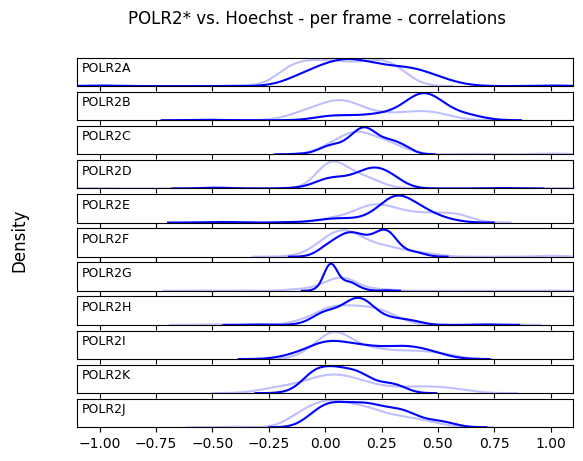

In [29]:
to_plot = {k : np.ravel(v[0]) for k, v in corrs_shifted.items()}
fig, axes = plt.subplots(ncols=1, nrows=len(to_plot), sharex=True)

for i in range(len(corrs_shifted.keys())):
    k = list(to_plot.keys())[i]
    ax_to_use = axes[i]
    sns.kdeplot(x=np.ravel(corrs_shifted[k][0]), ax=ax_to_use, label=k,alpha=0.25,c="b")
    sns.kdeplot(x=np.ravel(corrs_shifted[k][1]), ax=ax_to_use, label=k,c="b")
    ax_to_use.set_ylabel("")
    ax_to_use.set_yticks([])
    ax_to_use.set_xlim((-1.1,1.1))
    ax_to_use.text(0.01,0.5, k, transform=ax_to_use.transAxes, size=9)

fig.supylabel("Density")
fig.suptitle("POLR2* vs. Hoechst - per frame - correlations")

In [28]:
import pickle
with open("pol_shifted_imgs.pickle", "wb") as output_file:
    pickle.dump(shifted_imgs, output_file)

In [9]:
import pickle
with open("pol_shifted_imgs.pickle", "rb") as input_file:
    shifted_imgs = pickle.load(input_file)

### heterochromatin correlations

In [10]:
def generate_brightness_filtered(a,b,pct_cutoff=0.60,comparison=lambda x,cutoff:np.where(x>cutoff), show_imgs=False):
    good = ~np.logical_or(np.isnan(a), np.isnan(b))
    good_a = a[good]
    good_b = b[good]
    if len(good_a) < 2 or len(good_b) < 2:
        return np.nan, np.nan
    cutoff = np.quantile(good_a, pct_cutoff)
    het_a = good_a[comparison(good_a,cutoff)]
    het_b = good_b[comparison(good_a,cutoff)]
    return het_a, het_b

def correlate_het_mask_nans (a,b,cutoff=0.60,show_imgs = False):
    het_a, het_b = generate_brightness_filtered(a,b,pct_cutoff=cutoff,comparison=lambda x,cutoff:np.where(x>cutoff),show_imgs=show_imgs)
    if len(het_a) < 2 or len(het_b) < 2:
        return np.nan, np.nan
    return scipy.stats.pearsonr(np.ravel(het_a), np.ravel(het_b))

def correlate_euc_mask_nans (a,b,cutoff=0.60,show_imgs = False):
    euc_a, euc_b = generate_brightness_filtered(a,b,pct_cutoff=cutoff,comparison=lambda x,cutoff:np.where(x<=cutoff),show_imgs=show_imgs)
    if len(euc_a) < 2 or len(euc_b) < 2:
        return np.nan, np.nan
    return scipy.stats.pearsonr(np.ravel(euc_a), np.ravel(euc_b))

def pixel_vals_het_mask_nans (a,b,cutoff=0.60,show_imgs = False):
    het_a, het_b = generate_brightness_filtered(a,b,pct_cutoff=cutoff,comparison=lambda x,cutoff:np.where(x>cutoff),show_imgs=show_imgs)
    if len(het_a) < 2 or len(het_b) < 2:
        return np.nan, np.nan
    return np.ravel(het_a), np.ravel(het_b)

def pixel_vals_euc_mask_nans (a,b,cutoff=0.60,show_imgs = False):
    euc_a, euc_b = generate_brightness_filtered(a,b,pct_cutoff=cutoff,comparison=lambda x,cutoff:np.where(x<=cutoff),show_imgs=show_imgs)
    if len(euc_a) < 2 or len(euc_b) < 2:
        return np.nan, np.nan
    return np.ravel(euc_a), np.ravel(euc_b)


def plot_subunit_kde_shiftedres (subunit_dict, title=None):
    fig, axes = plt.subplots(ncols=1, nrows=len(subunit_dict), sharex=True)

    for i in range(len(subunit_dict.keys())):
        k = list(subunit_dict.keys())[i]
        ax_to_use = axes[i]
        shifted = np.hstack([x[1] for x in subunit_dict[k]])
        sns.kdeplot(x=shifted, ax=ax_to_use, label=k)
        ax_to_use.set_ylabel("")
        ax_to_use.set_yticks([])
        ax_to_use.set_xlim((-1,1))
        ax_to_use.text(0.01,0.5, k, transform=ax_to_use.transAxes, size=9)

    fig.supylabel("Density")
    fig.suptitle(title)

In [11]:
hoechst_het_corrs_shifted = compare_shifted(shifted_res, fn = lambda a,b :correlate_het_mask_nans(a,b)[0], per_frame=False, flatten=True, artifact_filter_level=50)
hoechst_het_vals_shifted = compare_shifted(shifted_res, fn = lambda a,b :pixel_vals_het_mask_nans(a,b), per_frame=False, flatten=True, artifact_filter_level=50)

100%|██████████| 58/58 [00:01<00:00, 32.39it/s]


In [12]:
hoechst_euc_corrs_shifted = compare_shifted(shifted_res, fn = lambda a,b :correlate_euc_mask_nans(a,b)[0], per_frame=False, flatten=True, artifact_filter_level=50)
hoechst_euc_vals_shifted = compare_shifted(shifted_res, fn = lambda a,b :pixel_vals_euc_mask_nans(a,b), per_frame=False, flatten=True, artifact_filter_level=50)

  0%|          | 0/76 [00:00<?, ?it/s]

100%|██████████| 58/58 [00:02<00:00, 25.74it/s]


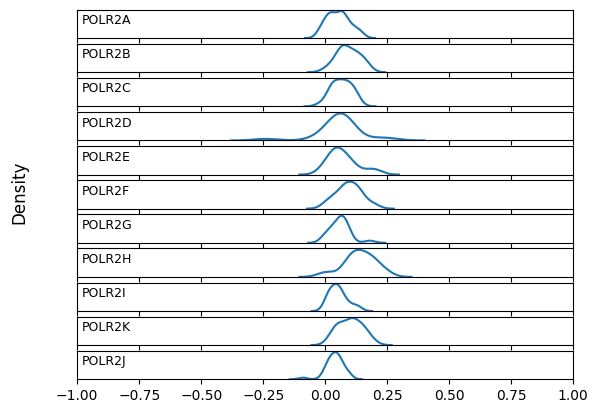

In [62]:
plot_subunit_kde_shiftedres(hoechst_het_corrs_shifted)

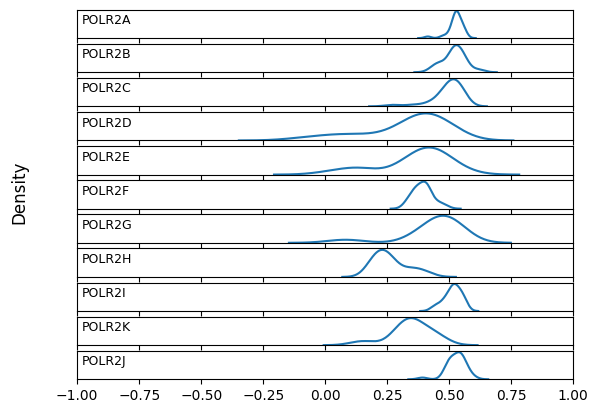

In [63]:
plot_subunit_kde_shiftedres(hoechst_euc_corrs_shifted)

In [24]:
[len(x[1]) for x in hoechst_het_vals_shifted["POLR2A"]]

[2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

#### sanity check

POLR2A
POLR2A
POLR2B
POLR2C
POLR2D
POLR2E
POLR2F
POLR2G
POLR2H
POLR2I
POLR2K


Text(0.02, 0.5, 'Density')

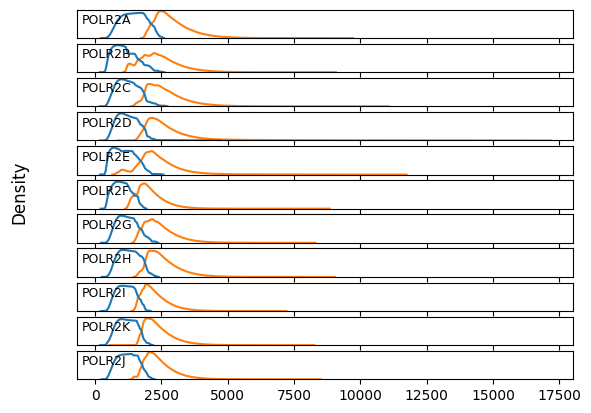

In [18]:
fig, axes = plt.subplots(ncols=1, nrows=len(hoechst_het_vals_shifted), sharex=True)

subunits =list(hoechst_het_vals_shifted.keys())
for i in range(len(subunits)):
    print(k)
    k = subunits[i]
    ax_to_use = axes[i]
    het_vals = np.hstack([x[1][0] for x in hoechst_het_vals_shifted[k]])
    euc_vals = np.hstack([x[1][0] for x in hoechst_euc_vals_shifted[k]])
    sns.kdeplot(x=het_vals, ax=ax_to_use, label=k,c='tab:orange')
    sns.kdeplot(x=euc_vals, ax=ax_to_use,c='tab:blue')
    ax_to_use.set_ylabel("")
    ax_to_use.set_yticks([])
    #ax_to_use.set_xlim(0,20000)
    ax_to_use.text(0.01,0.5, k, transform=ax_to_use.transAxes, size=9)

fig.supylabel("Density")
#fig.suptitle(title)

#### Protein brightnesses

POLR2J
POLR2A
POLR2B
POLR2C
POLR2D
POLR2E
POLR2F
POLR2G
POLR2H
POLR2I
POLR2K


Text(0.02, 0.5, 'Density')

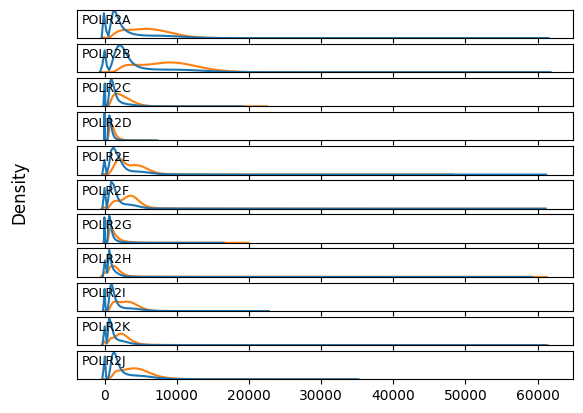

In [ ]:
fig, axes = plt.subplots(ncols=1, nrows=len(hoechst_het_vals_shifted), sharex=True)

subunits =list(hoechst_het_vals_shifted.keys())
for i in range(len(subunits)):
    print(k)
    k = subunits[i]
    ax_to_use = axes[i]
    het_vals = np.hstack([x[1][1] for x in hoechst_het_vals_shifted[k]])
    euc_vals = np.hstack([x[1][1] for x in hoechst_euc_vals_shifted[k]])
    sns.kdeplot(x=het_vals, ax=ax_to_use, label=k,c='tab:orange')
    sns.kdeplot(x=euc_vals, ax=ax_to_use,c='tab:blue')
    ax_to_use.set_ylabel("")
    ax_to_use.set_yticks([])
    #ax_to_use.set_xlim(0,20000)
    ax_to_use.text(0.01,0.5, k, transform=ax_to_use.transAxes, size=9)

fig.supylabel("Density")
#fig.suptitle(title)

#### heterochromatin brightness comp

In [8]:
fig, axes = plt.subplots(ncols=int(np.sqrt(len(hoechst_het_vals_shifted))), nrows=int(np.ceil(np.sqrt(len(hoechst_het_vals_shifted)))))
axes_flat = np.ravel(axes)
subunits =list(hoechst_het_vals_shifted.keys())
for i in range(len(subunits)):
    k = subunits[i]
    print(k)
    ax_to_use = axes_flat[i]
    hoechst_vals = np.hstack([x[1][0] for x in hoechst_het_vals_shifted[k]])
    prot_vals = np.hstack([x[1][1] for x in hoechst_het_vals_shifted[k]])
    # euc_vals = np.hstack([x[1][0] for x in hoechst_euc_vals_shifted[k]])
    sns.histplot(x=hoechst_vals, y=prot_vals, ax=ax_to_use,kde=True)
    ax_to_use.set_ylabel("")
    ax_to_use.set_yticks([])
    ax_to_use.set_xlabel("")
    ax_to_use.set_xticks([])
    #ax_to_use.set_xlim(0,20000)
    ax_to_use.text(0.02,0.8, k, transform=ax_to_use.transAxes, size=9)

fig.delaxes(axes_flat[-1])
fig.supylabel("Protein stain brightness")
fig.supxlabel("Hoechst stain brightness")

#fig.suptitle(title)

NameError: name 'hoechst_het_vals_shifted' is not defined

#### euch brightness comp

POLR2A
POLR2B
POLR2C
POLR2D
POLR2E
POLR2F
POLR2G
POLR2H
POLR2I
POLR2K
POLR2J


Text(0.5, 0.01, 'Hoechst stain brightness')

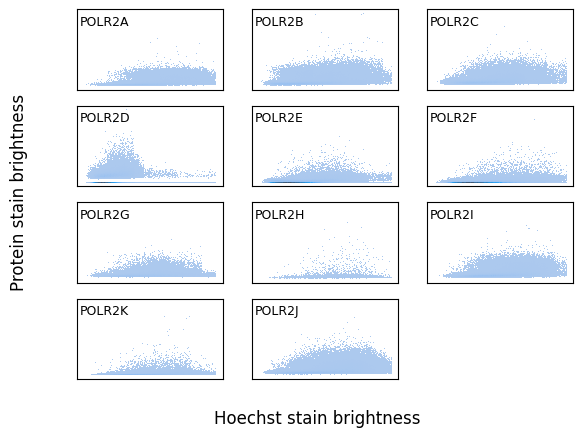

In [19]:
fig, axes = plt.subplots(ncols=int(np.sqrt(len(hoechst_het_vals_shifted))), nrows=int(np.ceil(np.sqrt(len(hoechst_het_vals_shifted)))))
axes_flat = np.ravel(axes)
subunits =list(hoechst_het_vals_shifted.keys())
for i in range(len(subunits)):
    k = subunits[i]
    print(k)
    ax_to_use = axes_flat[i]
    hoechst_vals = np.hstack([x[1][0] for x in hoechst_euc_vals_shifted[k]])
    prot_vals = np.hstack([x[1][1] for x in hoechst_euc_vals_shifted[k]])
    sns.histplot(x=hoechst_vals, y=prot_vals,kde=True, ax=ax_to_use,legend=False)
    ax_to_use.set_ylabel("")
    ax_to_use.set_yticks([])
    ax_to_use.set_xlabel("")
    ax_to_use.set_xticks([])
    #ax_to_use.set_xlim(0,20000)
    ax_to_use.text(0.02,0.8, k, transform=ax_to_use.transAxes, size=9)

fig.delaxes(axes_flat[-1])
fig.supylabel("Protein stain brightness")
fig.supxlabel("Hoechst stain brightness")
#fig.supylabel("Density")
#fig.suptitle(title)

# brightness w/ artifact removal

In [12]:
hoechst_brightnesses = {}
for subunit, cells in shifted_res.items():
    res = []
    print(subunit)
    for c in tqdm(cells):
        cell_stack_c0, cell_stack_c1, cell_stack_mask, c1_shifted = c
        # print(np.shape(cell_stack_c0))
        if np.shape(cell_stack_c0)[1] < 50 or np.shape(cell_stack_c0)[2] < 50:
            continue 
        res = res + list((np.ravel(cell_stack_c0[np.where(cell_stack_mask!=0)])))
    hoechst_brightnesses[subunit] = np.array(res)

POLR2A


100%|██████████| 76/76 [00:06<00:00, 11.92it/s]


POLR2B


100%|██████████| 753/753 [00:01<00:00, 720.43it/s]


POLR2C


100%|██████████| 48/48 [00:01<00:00, 25.24it/s]


POLR2D


100%|██████████| 182/182 [00:01<00:00, 111.88it/s]


POLR2E


100%|██████████| 228/228 [00:01<00:00, 139.36it/s]


POLR2F


100%|██████████| 410/410 [00:01<00:00, 284.71it/s]


POLR2G


100%|██████████| 91/91 [00:01<00:00, 49.90it/s]


POLR2H


100%|██████████| 53/53 [00:01<00:00, 31.58it/s]


POLR2I


100%|██████████| 46/46 [00:01<00:00, 38.32it/s]


POLR2K


100%|██████████| 57/57 [00:01<00:00, 43.72it/s]


POLR2J


100%|██████████| 58/58 [00:02<00:00, 21.97it/s]


In [6]:
len(hoechst_brightnesses['POLR2A'])

21758968

POLR2A
POLR2B
POLR2C
POLR2D
POLR2E
POLR2F
POLR2G
POLR2H
POLR2I
POLR2K
POLR2J


Text(0.5, 0.98, 'Hoechst Brightnesses')

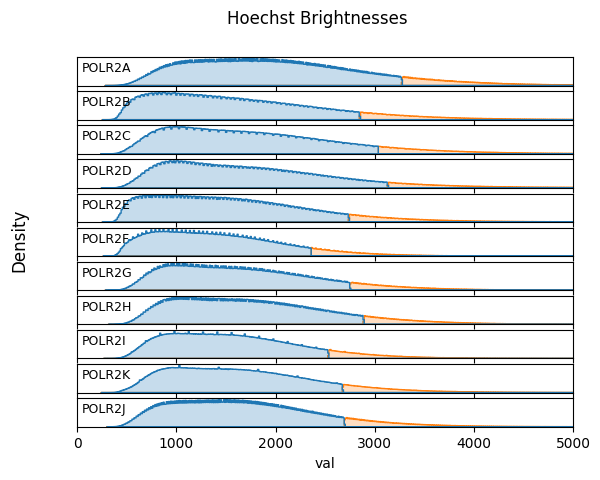

In [26]:
import pandas as pd
fig, axes = plt.subplots(ncols=1, nrows=len(hoechst_brightnesses), sharex=True)

for i in range(len(hoechst_brightnesses.keys())):
    k = list(hoechst_brightnesses.keys())[i]
    print(k)
    ax_to_use = axes[i]
    #sns.histplot(x=, ax=ax_to_use, label=k,element="step")
    het_cutoff = np.quantile(hoechst_brightnesses[k],0.90)
    s = pd.DataFrame({'val': hoechst_brightnesses[k], 'col':['1' if x>het_cutoff else '0' for x in hoechst_brightnesses[k]]})
    sns.histplot(data=s, x="val", hue="col",element='step',ax=ax_to_use,legend=False)
    ax_to_use.set_ylabel("")
    ax_to_use.set_yticks([])
    ax_to_use.set_xlim((0,5000))
    ax_to_use.text(0.01,0.5, k, transform=ax_to_use.transAxes, size=9)

fig.supylabel("Density")
fig.suptitle("Hoechst Brightnesses")